In [2]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
from qiskit.circuit import Parameter
import math
import random
import numpy as np
import copy
import time
from scipy.optimize import minimize
from qiskit.quantum_info.operators import Operator
from typing import Optional, List, Dict, Tuple, Union
from qiskit.result import Counts, Result

from qiskit import pulse, IBMQ
from qiskit.pulse.schedule import ScheduleBlock
from qiskit.pulse import Schedule
from qiskit.pulse.instructions import Call
from qiskit import transpile, schedule as build_schedule
from qiskit.providers.aer.pulse import duffing_system_model


import logging
logger = logging.getLogger()

# imports for qiskit dynamics simulation
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector

# optimizers
import random
from scipy.optimize import fmin_l_bfgs_b
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import QNSPSA

from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer, ActiveSpaceTransformer
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


# Define the system (backend and noise)

In [ ]:
IBMQ.ibmq.load_account()

In [6]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_manila = provider.get_backend('ibmq_manila')
manila_prop = backend_manila.properties()

In [ ]:
# build the noise model
import qiskit_aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

t1 = 100e3
t2 = 100e3

noise_thermal = qiskit_aer.noise.NoiseModel.from_backend(backend_manila, gate_error=True, thermal_relaxation=False,
                                                      readout_error=False)

for i in range(5):
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('reset', i)),
                                    "reset", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('id', i)),
                                    "id", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('sx', i)),
                                    "sx", [i])
    noise_thermal.add_quantum_error(thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('x', i)),
                                    "x", [i])
    for j in range(5):
        try:
            noise_thermal.add_quantum_error(
                thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j])).expand(
                    thermal_relaxation_error(t1, t2, 1e9 * manila_prop.gate_length('cx', [i,j]))),
                                            "cx", [i, j])
        except:
            pass


# Define functions to run the simulation

In [10]:
def run_ansatz(circ, noise):
    sim_backend = AerSimulator(noise_model=noise)
    circ.snapshot('final', snapshot_type='density_matrix')
    circ_tthermal = transpile(circ, sim_backend, optimization_level=0)
    
    job = sim_backend.run(circ_tthermal)
    density_matrix_res = job.result().data(0)['snapshots']['density_matrix']['final'][0]['value']
    return density_matrix_res

In [11]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

In [12]:
from qiskit.result import marginal_counts
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def finite_sampling_measure(state, paulis, coeffs, leakage=False, shots=10000):
    ansatz_density_matrix = qiskit.quantum_info.DensityMatrix(state)
    if leakage:
        # filter out leakage
        wanted_indexes = [0, 1, 3, 4, 9, 10, 12, 13, 27, 28, 30, 31, 36, 37, 39, 40]
        matrix = []
        for i in wanted_indexes:
            temp_row = []
            for j in wanted_indexes:
                temp_row.append(ansatz_density_matrix.data[i, j])
            matrix.append(temp_row)
        reduced_density_matrix = qiskit.quantum_info.DensityMatrix(matrix)
        leakage_prob = 1 - sum(reduced_density_matrix.probabilities())
        print("leakage percent: " + str(leakage_prob*100) + "%")
        ansatz_density_matrix = reduced_density_matrix / reduced_density_matrix.trace()

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = list(range(4))
        qubits_to_marginalize_out = []
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                qubits_to_marginalize_out.append(i)

        measured_density_matrix = ansatz_density_matrix.evolve(measure_op)

        if shots is not None:
            counts = measured_density_matrix.sample_counts(shots)
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                counts = marginal_counts(counts, marginal_qubits)
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_density_matrix.probabilities_dict()
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                probs = marginal_counts(probs, marginal_qubits)
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

In [13]:
def evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots=None):
    ansatz_circ = ansatz(num_of_qubits, num_of_layers)
    binded_circ = ansatz_circ.bind_parameters(theta)
        
    print(theta)
    ansatz_result = run_ansatz(binded_circ, noise_model)
    expval, stddev = finite_sampling_measure(ansatz_result, paulis[1:], coeffs[1:], leakage=False, shots=shots)
    print("energy: " + str(expval + coeffs[0]))
    # in case I will want to return also the varience
    # return expval, stddev
    
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    states.append(ansatz_result)
    return expval.real

In [14]:
def calculate_energy(theta):
    paulis = all_paulis[-1]
    coeffs = all_coeffs[-1]
    noise_model = noise_thermal
    num_of_qubits = 4
    num_of_layers = 1
    shots = 10000
    energy = evaluate_energy(theta, paulis, coeffs, noise_model, num_of_qubits, num_of_layers, shots)
    return energy

## Define the ansatz

In [15]:
def ansatz(num_of_qubits, num_of_layers):
    circ = QuantumCircuit(num_of_qubits)
    counter = 0
    for i in range(num_of_qubits):
        circ.ry(Parameter('θ_' + str(counter)), i)
        counter += 1
    for layer in range(num_of_layers):
        # alternating entangling layer
        for i in range(0, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(1, num_of_qubits-1, 2):
            circ.cx(i, i+1)
        for i in range(num_of_qubits):
            circ.ry(Parameter('θ_' + str(counter)), i)
            counter += 1
    return circ

# Functions to build the problem parameters

In [16]:
def get_qubit_op(dist, mapper="parity"):
    molecule = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver, 
                                            transformers=[ActiveSpaceTransformer(num_electrons=2, 
                                                                                 num_molecular_orbitals=3,
                                                                                active_orbitals=[1,2,5])])
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

### need also a function to get the hamiltonian without the active space approximation

In [17]:
def get_qubit_op_full(dist, mapper="parity"):
    molecule = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [18]:
def get_hf_energy(dist):
    temp_mol = gto.M(atom = 'Li 0 0 0; H 0 0 ' + str(dist), basis = 'sto3g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [19]:
def get_accurate_state(dist):
    temp_qubit_op = get_qubit_op(dist)[0]
    eigen_values, eigen_vectors = np.linalg.eigh(temp_qubit_op.to_matrix())
    min_eigen_value = eigen_values[0]
    min_eigen_vector = eigen_vectors.transpose()[0]
    return min_eigen_value, min_eigen_vector

In [20]:
def get_exact_energies(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

def get_exact_energies_full_space(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op_full(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [21]:
def get_paulis_and_coeffs(dist):
    qubit_op = get_qubit_op(dist)[0]
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

# Visualisation functions

In [22]:
def plot_convergence(values_hist_arr, dist, const_to_add=0):
    values_hist_arr_real = np.array(values_hist_arr[dist])
#     paulis, coeffs = get_paulis_and_coeffs(dist)
#     values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = values_hist_arr_real + const_to_add
    values_hist_arr_real = np.array([value.real for value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
#     min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_hist_arr[dist]))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_hist_arr[dist]))), [min_energy] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [Hartree]")
    plt.legend(frameon=False)
    plt.title("Convergence")
    plt.show()
    
def plot_convergence2(values_list, dist, const_to_add=0):
    values_hist_arr_real = np.array(values_list)
#     paulis, coeffs = get_paulis_and_coeffs(dist)
#     values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = values_hist_arr_real + const_to_add
    values_hist_arr_real = np.array([value.real for value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
#     min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_list))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_list))), [min_energy] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [Hartree]")
    plt.legend(frameon=False)
    plt.title("Convergence")
    plt.show()

In [23]:
def plot_energies(energies, calculated_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, energies, lw=3, label="Exact Energy")
    plt.plot(distances, calculated_energies, lw=3, label="VQE Energy")
    plt.fill_between(distances, np.array(energies)-0.0016, np.array(energies)+0.0016, 
                     alpha=0.2, facecolor='#089FFF', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [24]:
def plot_energies_error(energies, hf_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, np.abs(np.array(energies) - np.array(hf_energies)), lw=3, label="HF")
    plt.axhline(0.0016, linestyle='--', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy Error')
    plt.legend()
    plt.show()

# Run the simulation

In [233]:
# with noise_thermal and 400 iterations
from qiskit.algorithms.optimizers import SPSA

dists = [0.3, 0.5, 1, 1.5, 2, 2.5, 3]

thetas_hist = {}
values_hist = {}
states_hist = {}
all_paulis = []
all_coeffs =[]

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy - nuclear_repulsion_energy

    # make the HF state after the entangling gate, for faster convergance
    initial_theta = [0, 0, 0, 0, np.pi, np.pi, 0, 0]

    thetas = []
    values = []
    states = []

    tic = time.perf_counter()
    spsa = SPSA(maxiter=400)
    vqe_result = spsa.minimize(calculate_energy, initial_theta)
    toc = time.perf_counter()

    thetas_hist[dist] = copy.deepcopy(thetas)
    values_hist[dist] = copy.deepcopy(values)
    states_hist[dist] = copy.deepcopy(states)

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(thetas[opt_theta_index]))
    res = min(values).real + coeffs[0]
    print("min eigen_value found: " + str(res))
    print("absolute error: " + str(np.abs(res - target_energy)))
    print("number of function evaluations: " + str(vqe_result.nfev))

#########################################
Solving for distance 0.3:
#########################################
[-0.2         0.2         0.2        -0.2         2.94159265  2.94159265
 -0.2         0.2       ]
energy: (-0.8239213630166586+0j)
[ 0.2        -0.2        -0.2         0.2         3.34159265  3.34159265
  0.2        -0.2       ]
energy: (-0.817050368282505+0j)
[ 0.2         0.2        -0.2         0.2         2.94159265  3.34159265
 -0.2        -0.2       ]
energy: (-0.8190579572067902+0j)
[-0.2        -0.2         0.2        -0.2         3.34159265  2.94159265
  0.2         0.2       ]
energy: (-0.8246104132841567+0j)
[ 0.2        -0.2        -0.2        -0.2         2.94159265  2.94159265
 -0.2         0.2       ]
energy: (-0.8225143490440776+0j)
[-0.2         0.2         0.2         0.2         3.34159265  3.34159265
  0.2        -0.2       ]
energy: (-0.8216709232212769+0j)
[-0.2         0.2         0.2         0.2         2.94159265  2.94159265
  0.2        -0.2       ]


energy: (1.2188014686310542+0j)
[ -3.37458724  48.96864732  62.99070972 -28.11189644   0.18754832
  -4.39872162  -7.86894267  -2.1806469 ]
energy: (0.30344373930161256+0j)
[ -3.70321563  49.29727572  62.66208132 -27.78326804   0.51617672
  -4.72735002  -7.54031427  -1.85201851]
energy: (0.8031929956351327+0j)
[ 13.48372444  32.11033565  79.84902139 -44.97020811 -16.67076335
  12.45959005 -24.72725434 -18.71473253]
energy: (0.5513750612583602+0j)
[ 13.15949839  32.4345617   79.52479534 -44.64598206 -16.3465373
  12.135364   -24.4030283  -19.03895857]
energy: (0.8541144510952177+0j)
[ 22.71427936  22.55938885  89.39996819 -54.20076303 -25.90131827
  21.69014497 -34.27820114  -9.16378573]
energy: (-0.11535606114379643+0j)
[ 23.03467124  22.87978073  89.07957631 -54.52115491 -26.22171015
  22.01053685 -33.95780927  -9.4841776 ]
energy: (0.07769620187444304+0j)
[ 17.29032829  16.81843725  94.82391926 -48.45981143 -20.16036667
  16.26619391 -39.70215221  -3.42283413]
energy: (0.2437923893758

energy: (0.7856143799417363+0j)
[ -1.90945754  16.69195775  93.99116828 -64.33842549  -8.82977269
  27.86646952 -42.44173613  -1.50867371]
energy: (0.763323659775393+0j)
[ -1.96238867  16.36126539  93.66047592 -64.00773314  -8.49908034
  28.19716187 -42.11104377  -1.17798135]
energy: (0.4871973512593711+0j)
[ -2.24014989  16.63902662  93.93823715 -64.28549436  -8.77684156
  27.91940065 -42.388805    -1.45574258]
energy: (0.6057994235600495+0j)
[ -0.50223174  14.62409439  92.200319   -62.27056213  -7.03892341
  29.6573188  -40.37387277   0.55918965]
energy: (0.34791448070511266+0j)
[ -0.22521766  14.90110847  91.92330492 -62.54757621  -6.76190933
  29.93433288 -40.65088685   0.28217557]
energy: (0.42874399749252834+0j)
[ -1.39403328  13.45600457  93.36840882 -61.10247231  -8.20701323
  28.76551726 -39.20578295   1.45099119]
energy: (0.5703758839786571+0j)
[ -1.67032156  13.73229285  93.09212053 -61.3787606   -7.93072495
  28.48922898 -39.48207123   1.72727947]
energy: (0.739793515880473

energy: (0.37764119136177937+0j)
[ 13.55688239  -1.74593533  60.75347973 -28.94139228  12.87764475
  25.32998484 -64.81070248  21.96024277]
energy: (0.37085303201351505+0j)
[ 13.8188732   -1.48394452  61.01547054 -28.67940147  12.61565394
  25.06799403 -64.54871167  22.22223358]
energy: (0.39957931909385275+0j)
[ 13.24216085  -2.06065688  60.70035138 -28.99452063  12.9307731
  25.38311319 -65.12542402  21.90711442]
energy: (0.21289102842701355+0j)
[ 13.50375404  -1.79906368  60.43875819 -29.25611382  13.19236629
  25.64470638 -64.86383083  21.64552123]
energy: (0.3580001343507772+0j)
[ 11.66349529  -3.63932243  62.01781489 -27.41585507  11.6133096
  23.80444763 -66.44288752  23.48577998]
energy: (0.8762406970363656+0j)
[ 11.92469735  -3.37812038  62.27901694 -27.67705712  11.35210754
  24.06564969 -66.70408958  23.22457792]
energy: (0.2671929574324739+0j)
[ 18.24143392   2.93861619  68.85657072 -34.2546109    4.77455377
  30.38238626 -73.02082615  16.90784135]
energy: (0.04965168404464

energy: (0.16629699040799806+0j)
[ 20.23766769   2.31811554  59.34972174 -24.33118333  24.15241432
  17.83903993 -80.49999846  33.96235311]
energy: (0.13212156271688028+0j)
[ 20.54970135   2.37788792  59.6617554  -24.27141095  24.21218671
  18.15107359 -80.44022607  34.02212549]
energy: (0.21237554008887807+0j)
[ 20.29744007   2.6301492   59.40949412 -24.01914967  24.46444799
  17.89881231 -80.18796479  34.27438678]
energy: (0.19437325124277907+0j)
[ 20.13399489   2.79359439  59.24604894 -23.85570448  24.62789317
  17.73536713 -80.02451961  34.43783196]
energy: (0.16624766618259387+0j)
[ 20.38599228   2.54159699  59.49804633 -24.10770187  24.37589578
  17.98736452 -80.276517    34.18583457]
energy: (0.19855619125249294+0j)
[ 20.09381181   3.08551395  58.95412937 -23.56378492  24.66807625
  17.44344757 -79.73260005  34.72975152]
energy: (0.11230793316090029+0j)
[ 19.84207533   2.83377747  59.20586586 -23.8155214   24.91981273
  17.69518405 -79.98433653  34.47801504]
energy: (0.089246154

energy: (0.732193644235863+0j)
[ 25.12919863  -2.71181499  61.4234665  -16.87707021  27.04903975
  13.7811719  -84.93028863  33.88876832]
energy: (0.19746210341392212+0j)
[ 24.88357391  -2.46619027  61.17784177 -16.63144548  27.29466447
  13.53554717 -84.6846639   34.13439304]
energy: (-0.058399972738868045+0j)
[ 23.09221373  -0.42940296  59.3864816  -14.59465818  29.33145178
  11.744187   -82.89330373  35.92575322]
energy: (0.770737602600003+0j)
[ 22.8467866   -0.67483009  59.14105447 -14.84008531  29.08602465
  11.49875987 -82.6478766   36.17118035]
energy: (0.6637149718481554+0j)
[ 21.99828514  -1.2781003   58.292553   -15.44335552  28.48275444
  10.6502584  -82.04460639  36.77445056]
energy: (0.4674284255197541+0j)
[ 22.24351639  -1.52333155  58.53778426 -15.68858677  28.23752319
  10.89548966 -81.79937513  37.01968181]
energy: (0.0824519951510414+0j)
[ 25.03885571  -4.56370794  61.57816064 -18.48392608  25.44218387
  13.93586604 -79.00403582  39.81502113]
energy: (0.67838273664536

energy: (-0.16880328753217738+0j)
[ 19.4855404    6.18186238  66.88045148 -29.09641372  25.77865951
   9.78451643 -79.28262729  35.2727304 ]
energy: (-0.19945732463973825+0j)
[ 19.46492862   6.16125059  66.8598397  -29.31614771  25.79927129
   9.80512821 -79.30323907  35.05299641]
energy: (-0.18041660598585324+0j)
[ 19.70527439   6.40159637  67.10018547 -29.07580194  25.55892551
   9.56478244 -79.06289329  35.29334219]
energy: (-0.1982898244877817+0j)
[ 19.59275618   6.28907816  66.98766726 -28.94813043  25.67144372
   9.67730065 -78.93522179  35.18082398]
energy: (-0.08543952180360198+0j)
[ 19.8329459    6.52926787  67.22785698 -29.18832015  25.43125401
   9.43711093 -79.1754115   35.42101369]
energy: (-0.2775398088209791+0j)
[ 20.96146138   7.89781811  68.59640722 -30.31683563  24.06270377
   8.06856069 -80.30392699  36.54952918]
energy: (-0.13969342744862634+0j)
[ 21.20149614   7.65778336  68.35637247 -30.55687039  24.30273852
   8.30859545 -80.54396174  36.78956393]
energy: (0.0051

energy: (0.24610027822081848+0j)
[ 28.54872038   3.53764497  73.52672995 -42.73903783  15.49501806
   9.10987661 -78.49263683  45.50532505]
energy: (0.2703367551944499+0j)
[ 28.7849386    3.30142675  73.76294816 -42.50281961  15.25879984
   8.87365839 -78.25641861  45.26910684]
energy: (0.2778525134687947+0j)
[ 28.499489     3.58687635  73.71358751 -42.55218026  15.54424943
   8.92301904 -78.30577926  45.31846749]
energy: (0.21331901631150937+0j)
[ 28.73557794   3.35078741  73.47749857 -42.78826921  15.30816049
   9.15910799 -78.5418682   45.55455643]
energy: (0.32046700008032303+0j)
[ 28.03463362   4.05173173  74.41440332 -41.85136445  16.24506525
   8.45816366 -77.84092388  44.85361211]
energy: (0.19432711605785566+0j)
[ 27.79867319   4.28769216  74.17844289 -42.08732488  16.00910481
   8.22220323 -77.60496345  44.61765168]
energy: (0.05977544249110922+0j)
[ 26.92097691   5.16538844  73.5365793  -42.72918848  15.36724122
   7.58033964 -76.96309985  43.97578808]
energy: (-0.1545777982

energy: (-0.4780616447939789+0j)
[ 21.5378849   -1.9745207   74.63004188 -41.23752057  13.92132382
   2.80695228 -79.33614805  47.74557414]
energy: (-0.465986315449985+0j)
[ 21.46422719  -2.28082045  74.70369959 -41.54382032  13.99498152
   3.11325203 -79.26249035  47.43927439]
energy: (-0.4631003172408012+0j)
[ 21.23158515  -2.0481784   74.93634163 -41.31117828  14.22762357
   2.88060999 -79.02984831  47.67191643]
energy: (-0.47302847699268685+0j)
[ 21.17126671  -1.98785996  74.76412755 -41.48339236  14.28794201
   3.05282407 -78.96952986  47.49970235]
energy: (-0.3838666109845493+0j)
[ 21.40379923  -2.22039249  74.99666007 -41.25085984  14.05540948
   2.82029155 -79.20206239  47.73223487]
energy: (-0.5610040287602214+0j)
[ 22.24598192  -3.06257518  75.83884277 -40.17625357  12.98080322
   1.74568529 -80.04424508  48.57441756]
energy: (0.7745867801896396+0j)
[ 22.47840549  -3.29499875  76.07126633 -40.40867714  13.21322679
   1.97810885 -80.27666865  48.80684113]
energy: (0.6097932902

energy: (0.27141293434124236+0j)
[ 12.43353332  -0.75230159  81.68409562 -44.50125449  18.60309095
   3.08387557 -87.27521206  48.19235306]
energy: (0.3629420900821934+0j)
[ 12.2038583   -0.52262657  81.4544206  -44.27157947  18.37341593
   3.31355058 -87.04553705  48.42202808]
energy: (0.111556581713016+0j)
[ 10.76952587   0.91170586  80.24966795 -42.83724704  16.9390835
   4.51830324 -85.84078439  49.62678074]
energy: (-0.37768742592282095+0j)
[ 10.99910564   0.68212609  80.02008817 -43.06682682  17.16866328
   4.74788301 -85.61120462  49.85636051]
energy: (-0.08759774793915209+0j)
[  9.34723826   2.56347843  81.67195556 -41.41495943  15.51679589
   3.09601563 -87.263072    47.97500817]
energy: (-0.7387434723629911+0j)
[  9.1177533    2.33399348  81.90144052 -41.18547447  15.28731093
   2.86653067 -87.49255696  48.20449312]
energy: (-0.5111126356650573+0j)
[ 10.64070653   3.85694671  80.37848728 -42.70842771  16.5808736
   4.16009334 -85.96960373  46.91093045]
energy: (0.614387578345

energy: (-0.24042658593655614+0j)
[ 10.1518996    3.15561092  77.62543929 -44.71647195  12.81420766
  -3.91512703 -82.52193771  40.55234378]
energy: (-0.3791051273674321+0j)
[ 10.8996877    3.67640858  77.10464163 -43.96868385  12.06641956
  -3.39432936 -82.00114005  40.03154611]
energy: (0.16074719023164402+0j)
[ 10.67269726   3.90339902  76.87765119 -44.19567429  12.29340999
  -3.16733893 -81.77414961  39.80455568]
energy: (0.062362164780662754+0j)
[ 10.14316809   4.20602156  76.34812201 -44.49829683  12.59603254
  -2.86471638 -81.47152707  39.2750265 ]
energy: (-0.15348482183822848+0j)
[ 10.37007472   4.43292819  76.57502864 -44.72520346  12.82293917
  -2.63780975 -81.24462044  39.50193313]
energy: (-0.0334532852988636+0j)
[  9.49830582   3.78798245  75.9300829  -43.85343456  12.17799342
  -3.2827555  -81.88956618  38.85698739]
energy: (-0.2000827123377495+0j)
[  9.72512898   3.56115929  75.70325974 -44.08025772  11.95117027
  -3.50957865 -82.11638934  38.63016423]
energy: (-0.49392

energy: (-0.5591636492776668+0j)
[ 16.50589923   1.8707531   73.32427451 -42.56643879   5.08295002
  -3.55767481 -79.01710704  37.69703862]
energy: (0.8244299126843582+0j)
[ 16.73058692   2.0954408   73.54896221 -42.34175109   5.30763772
  -3.33298712 -79.24179473  37.47235093]
energy: (0.3302718988459886+0j)
[ 19.2592366    4.62409047  76.07761188 -40.03771411   7.61167471
  -1.02895013 -81.77044441  35.16831394]
energy: (0.4247089191009233+0j)
[ 19.03462391   4.39947779  75.85299919 -39.81310142   7.83628739
  -0.80433744 -81.54583172  34.94370125]
energy: (0.3019024925263192+0j)
[ 18.63181864   3.77213456  75.22565597 -39.1857582    8.23909266
  -0.17699422 -81.14302645  34.31635803]
energy: (-0.2427719865354087+0j)
[ 18.40728068   3.99667251  75.45019392 -39.41029615   8.46363062
  -0.40153217 -80.91848849  34.54089598]
energy: (0.012481657403412783+0j)
[ 19.70918015   2.69477305  73.92383097 -37.8839332    6.93726767
   0.90036729 -82.44485144  33.01453303]
energy: (-0.10354450072

energy: (-0.08309569816994844+0j)
[ 16.60264336   2.4859658   75.54257045 -36.26561563   7.33025614
   0.23014039 -82.17780385  28.74510729]
energy: (0.5943162941848061+0j)
[ 16.82525987   2.7085823   75.76518695 -36.04299913   7.10763963
   0.4527569  -81.95518734  28.96772379]
energy: (0.19156897570391207+0j)
[ 18.79361789   4.67694032  77.73354497 -34.2971898    5.13928161
   2.19856622 -79.98682932  30.93608181]
energy: (-0.060056068966209186+0j)
[ 18.57106919   4.45439163  77.51099628 -34.07464111   5.36183031
   2.42111491 -80.20937802  30.71353312]
energy: (0.24069451574678352+0j)
[ 20.0387751    6.14457864  79.20118329 -35.76482812   3.6716433
   0.73092791 -78.74167211  32.40372013]
energy: (1.3369535012474376+0j)
[ 20.2612562    5.92209754  78.97870219 -35.54234702   3.8941244
   0.95340901 -78.51919101  32.18123903]
energy: (0.6508578601238973+0j)
[ 23.60434926   2.80141821  75.63560913 -32.19925396   7.01480372
   4.29650206 -75.17609795  28.83814597]
energy: (0.91630065279

energy: (0.029572753711166633+0j)
[ 20.90143075   0.5644548   78.53450596 -32.48834202   7.0959434
   7.62580109 -76.23372499  34.53626089]
energy: (0.037204439810293255+0j)
[ 21.15789829   0.82092234  78.49871272 -32.52413526   7.06015017
   7.36933355 -76.26951823  34.27979335]
energy: (-0.14984295015036692+0j)
[ 20.93722399   0.60024804  78.27803842 -32.74480956   6.83947586
   7.59000785 -76.49019253  34.50046765]
energy: (0.22333462417206743+0j)
[ 22.68354805   2.3465721   80.02436248 -30.99848551   8.80641258
   5.62307114 -74.74386847  32.53353094]
energy: (0.5392435873513068+0j)
[ 22.9041607    2.56718475  80.24497513 -30.77787285   8.58579992
   5.84368379 -74.52325582  32.75414359]
energy: (0.7975773543307464+0j)
[ 21.47637406   1.1393981   78.81718848 -32.2056595    9.79303537
   4.63644834 -75.95104246  31.54690814]
energy: (0.7208548006242619+0j)
[ 21.69692525   1.3599493   79.03773968 -31.9851083   10.01358657
   4.41589715 -75.73049127  31.32635694]
energy: (0.8824146792

energy: (-0.43502230588384255+0j)
[ 25.05593004  -3.29752336  78.53513532 -31.48264901   9.00567039
   1.08245259 -77.83238     33.83225626]
energy: (-0.3896664706793124+0j)
[ 25.27488888  -3.51648219  78.75409415 -31.70160784   8.78671156
   0.86349376 -77.61342117  33.61329743]
energy: (-0.48960754763941733+0j)
[ 25.50587639  -3.7474697   79.20398387 -32.15149756   8.33682184
   0.63250624 -77.38243366  33.38230992]
energy: (-0.6330781998640984+0j)
[ 25.72477859  -3.96637191  78.98508167 -31.93259535   8.55572404
   0.41360404 -77.16353145  33.16340771]
energy: (-0.43245115304320664+0j)
[ 24.6038732   -2.84546651  79.88714132 -33.05350075   7.43481865
   1.53450944 -78.28443685  34.06546737]
energy: (0.2126961763151454+0j)
[ 24.82271894  -3.06431225  80.10598706 -32.83465501   7.65366439
   1.31566369 -78.06559111  34.28431311]
energy: (0.11943014172469246+0j)
[ 25.24148429  -3.4830776   80.30596298 -32.41588966   8.07242974
   0.89689835 -77.64682576  34.48428902]
energy: (-0.065395

energy: (-0.916606831629331+0j)
[ 0.2         0.2         0.2        -0.2         2.94159265  2.94159265
 -0.2         0.2       ]
energy: (-0.918834667583626+0j)
[-0.2         0.2         0.2         0.2         3.34159265  2.94159265
 -0.2         0.2       ]
energy: (-0.8734471251408088+0j)
[ 0.2        -0.2        -0.2        -0.2         2.94159265  3.34159265
  0.2        -0.2       ]
energy: (-0.8809498169229005+0j)
[ 0.2         0.2        -0.2        -0.2         2.94159265  2.94159265
  0.2        -0.2       ]
energy: (-0.88852698955946+0j)
[-0.2        -0.2         0.2         0.2         3.34159265  3.34159265
 -0.2         0.2       ]
energy: (-0.8757657423433157+0j)
[ 0.2        -0.2        -0.2        -0.2         3.34159265  3.34159265
  0.2         0.2       ]
energy: (-0.9269817434984872+0j)
[-0.2         0.2         0.2         0.2         2.94159265  2.94159265
 -0.2        -0.2       ]
energy: (-0.9103256669993831+0j)
[ 0.2         0.2         0.2         0.2      

energy: (-0.31737587833677294+0j)
[ 20.59189821  -2.90264855  -9.7360508  -45.50173442  -7.96885773
  -8.11501666 -14.86365158 -10.14890583]
energy: (-0.3165142326969188+0j)
[ 20.57927937  -2.59985561  -9.72343196 -45.80452737  -7.95623889
  -8.41780961 -14.87627042 -10.45169877]
energy: (-0.32758106776193846+0j)
[ 20.28910526  -2.89002972  -9.43325785 -45.51435326  -7.66606478
  -8.1276355  -15.16644453 -10.16152467]
energy: (-0.3207791764517321+0j)
[ 20.67136516  -2.50776982  -9.52653757 -45.60763299  -7.75934451
  -8.22091523 -14.78418463 -10.25480439]
energy: (-0.3779809229156117+0j)
[ 20.38238499  -2.79674999  -9.81551775 -45.89661316  -8.04832468
  -8.5098954  -15.0731648  -10.54378457]
energy: (-0.2767910308211636+0j)
[ 21.7338596   -1.15743767  -8.46404314 -44.54513855  -6.40901236
  -6.87058308 -13.72169019  -9.19230995]
energy: (-0.3854085024685815+0j)
[ 22.0216973   -1.44527538  -8.17620543 -44.25730085  -6.69685007
  -7.15842079 -13.43385249  -8.90447225]
energy: (-0.149748

energy: (-0.35626562415366075+0j)
[  9.2740497    0.47351536   5.92988453 -45.77941722 -11.55019293
 -17.27122948   0.57721178 -22.07030987]
energy: (-0.32576699602744763+0j)
[  9.54190986   0.2056552    5.66202437 -45.51155706 -11.28233276
 -17.53908965   0.30935162 -21.8024497 ]
energy: (-0.21933783454224304+0j)
[  8.29919249   1.18101763   6.63738679 -46.75427443 -12.25769519
 -16.29637227   1.55206899 -23.04516707]
energy: (-0.18492864172808204+0j)
[  8.56654743   1.44837257   6.90474174 -46.48691948 -12.52505014
 -16.56372722   1.28471405 -22.77781213]
energy: (-0.23751158240708298+0j)
[  8.77671721   1.92540227   7.38177144 -46.00988979 -12.73521991
 -17.04075692   1.07454428 -22.56764236]
energy: (0.10277111622689511+0j)
[  9.04357713   1.65854234   7.11491151 -46.27674971 -13.00207983
 -16.77389699   0.80768435 -22.30078243]
energy: (0.011510523619944164+0j)
[ 9.86409546e+00  8.38024015e-01  6.29439318e+00 -4.70972680e+01
 -1.38225982e+01 -1.62197534e+01 -1.28339783e-02 -2.1480

energy: (0.019593621964013614+0j)
[  6.22126175  -0.48336236   0.7381753  -49.13811491 -22.08704133
 -21.39240371 -12.50527123 -16.72390943]
energy: (0.02784801789648939+0j)
[  5.90433474  -0.4224313    0.67724424 -49.19904597 -21.77011432
 -21.70933072 -12.44434017 -16.40698242]
energy: (-0.044000519637704114+0j)
[  6.1603307   -0.16643534   0.42124829 -49.45504192 -22.02611028
 -21.45333476 -12.18834422 -16.66297837]
energy: (0.09040006221869584+0j)
[  5.17662216  -1.15014388   1.40495683 -48.47133338 -20.78671525
 -22.4370433  -13.42773925 -15.67926983]
energy: (-0.09115076940967219+0j)
[  4.92093567  -1.40583038   1.66064332 -48.21564689 -21.04240174
 -22.69272979 -13.17205276 -15.42358334]
energy: (-0.005363270076014951+0j)
[  5.8005134   -0.52625264   0.78106558 -48.83984357 -20.162824
 -21.81315206 -14.05163049 -16.04778002]
energy: (-0.23613259088069272+0j)
[  5.54513235  -0.7816337    1.03644664 -49.09522463 -20.41820506
 -22.06853312 -13.79624944 -16.30316108]
energy: (-0.046

energy: (-0.429521367283703+0j)
[  5.59712568  -3.50404231   8.12543818 -45.18304797 -12.24617739
 -25.45149813 -10.26698044 -16.51291373]
energy: (-0.5741757331656329+0j)
[  5.84548987  -3.25567812   8.37380237 -44.93468379 -11.9978132
 -25.20313394 -10.01861625 -16.26454954]
energy: (-0.5459128769706231+0j)
[  5.41924002  -3.43378666   7.94755253 -45.36093363 -12.17592174
 -25.62938379 -10.44486609 -16.69079939]
energy: (-0.616396903997188+0j)
[  5.66738133  -3.68192796   8.19569383 -45.11279232 -12.42406305
 -25.38124248 -10.19672478 -16.44265808]
energy: (-0.5705997695118393+0j)
[  5.38012608  -3.14675212   7.66051799 -45.40004758 -11.8888872
 -25.91641833 -10.48398004 -16.72991333]
energy: (-0.5296840463610405+0j)
[  5.13220548  -3.39467271   7.90843858 -45.64796817 -12.13680779
 -25.66849773 -10.73190063 -16.97783393]
energy: (-0.6210479005686759+0j)
[  4.80969471  -3.96488548   8.47865135 -46.21818095 -12.70702057
 -25.09828496 -11.30211341 -17.30034471]
energy: (-0.453498517796

energy: (-0.20750527920151834+0j)
[  5.97763232  -1.47475625   5.5868574  -46.04870295 -17.93918178
 -24.43477636  -8.99620147 -16.86849474]
energy: (-0.35039667240725614+0j)
[  6.5369312   -2.27653678   6.14615629 -45.48940406 -17.37988289
 -25.23655689  -9.79798199 -17.67027527]
energy: (-0.7778676228749807+0j)
[  6.77941285  -2.03405513   6.38863793 -45.24692242 -17.13740125
 -24.99407525  -9.55550035 -17.42779362]
energy: (-0.6862420098086899+0j)
[  6.26696658  -2.54650141   5.87619166 -46.00167853 -17.89215736
 -25.50652152 -10.06794662 -18.18254974]
energy: (-0.5416679726900299+0j)
[  6.02465673  -2.78881125   5.63388182 -45.75936869 -17.64984752
 -25.74883136 -10.31025646 -17.9402399 ]
energy: (-0.6618841100373692+0j)
[  5.59700518  -3.45860215   4.96409091 -45.08957779 -17.22219597
 -26.41862226 -10.98004737 -17.27044899]
energy: (-0.4416651226343866+0j)
[  5.35486583  -3.2164628    5.20623027 -45.33171714 -16.98005662
 -26.17648291 -10.73790801 -17.51258835]
energy: (-0.622799

energy: (-0.37606789044798883+0j)
[ 10.46241997 -10.16086871  15.87617786 -45.62284932 -16.43003239
 -26.95915042  -8.57497759 -16.80632498]
energy: (-0.4434742079449183+0j)
[ 10.70039281  -9.92289587  15.63820502 -45.38487649 -16.66800522
 -27.19712326  -8.81295043 -16.56835215]
energy: (-0.4637696298397507+0j)
[ 10.80372314 -10.05739828  15.77270743 -45.51937889 -16.53350282
 -27.30045358  -8.67844802 -16.46502182]
energy: (-0.37951754239328056+0j)
[ 10.56589041  -9.81956555  15.5348747  -45.28154616 -16.77133555
 -27.06262085  -8.91628075 -16.70285455]
energy: (-0.5212695712388+0j)
[ 10.08356709  -9.09954872  14.81485787 -44.79922285 -17.25365886
 -26.34260402  -9.39860407 -17.42287138]
energy: (-0.1054311490705501+0j)
[  9.84587358  -9.33724223  15.05255138 -44.56152933 -17.49135238
 -26.58029754  -9.63629758 -17.18517786]
energy: (-0.15899664030981928+0j)
[  9.57462444  -9.60849137  15.32380052 -44.52783538 -17.76260152
 -26.85154668  -9.90754672 -16.91392872]
energy: (-0.38118203

energy: (-0.48284404882227194+0j)
[  7.64519524 -13.22368748  19.72322735 -45.93176411 -21.49962017
 -28.25706857 -14.24436472 -17.67547748]
energy: (-0.4820354338975991+0j)
[  7.40720823 -13.46167449  19.71935964 -45.93563183 -21.49575245
 -28.26093629 -14.48235172 -17.43749048]
energy: (-0.5456957003627586+0j)
[  7.64132752 -13.2275552   19.48524035 -46.16975112 -21.26163317
 -28.49505557 -14.24823244 -17.67160976]
energy: (-0.38658865879428894+0j)
[  6.65971168 -13.97516908  20.23285422 -45.42213724 -22.24324901
 -27.7474417  -14.99584631 -16.68999392]
energy: (-0.21917181957615806+0j)
[  6.89371365 -14.20917104  20.46685619 -45.18813528 -22.00924704
 -27.51343974 -15.22984828 -16.92399589]
energy: (-0.12994156730008613+0j)
[  6.24156795 -13.79091062  20.04859577 -45.84028098 -22.66139274
 -27.93170015 -14.57770258 -16.50573547]
energy: (-0.3639047302939181+0j)
[  6.47545323 -13.55702534  19.81471049 -45.6063957  -22.42750746
 -28.16558543 -14.81158786 -16.27185019]
energy: (-0.4659

energy: (-0.7716592784053617+0j)
[  4.39050578 -10.86885492  17.74227231 -45.70779171 -20.4202147
 -30.40701928 -13.63941728 -17.44622309]
energy: (-0.7616292800603572+0j)
[  4.62145977 -10.63790093  17.51131832 -45.9387457  -20.65116869
 -30.17606529 -13.40846329 -17.21526909]
energy: (-0.8002056922758342+0j)
[  4.79082396 -10.69938956  17.34195413 -46.10810989 -20.58968006
 -30.23755392 -13.2390991  -17.27675772]
energy: (-0.7353306092966793+0j)
[  4.55997114 -10.46853674  17.57280695 -45.87725707 -20.82053288
 -30.0067011  -13.46995192 -17.04590491]
energy: (-0.8087117691737643+0j)
[  4.46920765 -10.14702113  17.89432256 -45.78649358 -21.14204849
 -29.68518549 -13.79146753 -16.95514142]
energy: (-0.7502385053719686+0j)
[  4.23845553 -10.37777325  17.66357044 -45.55574146 -20.91129637
 -29.91593761 -13.56071541 -16.72438929]
energy: (-0.7433540243015165+0j)
[  4.26860913 -10.11696775  17.69372404 -45.81654696 -21.17210187
 -29.88578401 -13.82152091 -16.9851948 ]
energy: (-0.751719521

energy: (-0.8045612371273826+0j)
[  3.54792597 -11.53869378  16.93099224 -45.33883552 -22.51669448
 -30.54471241 -14.01426941 -17.11054762]
energy: (-0.8537965366687684+0j)
[  3.57234579 -11.33500184  16.7273003  -45.13514358 -22.72038642
 -30.34102047 -14.03868923 -17.0861278 ]
energy: (-0.7979417211608232+0j)
[  3.34423403 -11.5631136   16.95541206 -45.36325535 -22.49227466
 -30.56913224 -13.81057746 -17.31423956]
energy: (-0.8493406477079125+0j)
[  3.13199901 -11.54732528  16.93962374 -45.34746702 -22.28003964
 -30.55334391 -13.82636579 -17.29845124]
energy: (-0.8579139834252856+0j)
[  3.36002235 -11.77534862  17.16764708 -45.57549036 -22.50806298
 -30.78136725 -13.59834245 -17.52647458]
energy: (-0.8324039717786746+0j)
[  3.25482358 -11.44221457  16.83451302 -45.47029159 -22.40286421
 -30.67616848 -13.70354122 -17.19334052]
energy: (-0.8357275417366219+0j)
[  3.0268883  -11.67014985  17.06244831 -45.24235631 -22.17492892
 -30.4482332  -13.9314765  -17.42127581]
energy: (-0.84616095

energy: (-0.7740116700944714+0j)
[  3.23629684 -13.01779829  16.89563045 -45.52017393 -22.00985786
 -30.95287205 -13.18934505 -16.98916535]
energy: (-0.7621018440035824+0j)
[  3.01060841 -12.79210985  16.66994202 -45.74586237 -22.2355463
 -30.72718362 -12.96365661 -17.21485379]
energy: (-0.7860204332872869+0j)
[  3.14257016 -12.69846189  16.80190377 -45.61390062 -22.32919426
 -30.85914537 -12.87000865 -17.30850175]
energy: (-0.8010020728527584+0j)
[  2.91696044 -12.9240716   16.57629405 -45.83951033 -22.10358455
 -30.63353565 -13.09561836 -17.08289204]
energy: (-0.6993515416259294+0j)
[  3.54000003 -12.5265633   16.97380235 -45.21647075 -22.50109285
 -31.03104395 -12.47257878 -17.48040034]
energy: (-0.7035688052352335+0j)
[  3.31446874 -12.30103201  17.19933364 -45.44200204 -22.72662413
 -31.25657524 -12.69811007 -17.70593162]
energy: (-0.7362947965109582+0j)
[  3.18676469 -12.17332796  17.32703769 -45.34425293 -22.85432819
 -31.15882614 -12.82581412 -17.83363568]
energy: (-0.720683707

energy: (-0.8166070589857409+0j)
[  2.95170009 -12.55552561  14.95051882 -45.36507239 -23.51473194
 -31.82527441 -12.35733302 -16.75189144]
energy: (-0.8312333351038902+0j)
[  2.78282641 -12.50095096  14.78164513 -45.19619871 -23.68360563
 -31.65640072 -12.5262067  -16.92076513]
energy: (-0.8524850635445305+0j)
[  3.00627475 -12.7243993   15.00509347 -45.41964705 -23.46015729
 -31.87984906 -12.30275836 -16.69731679]
energy: (-0.7826573837281725+0j)
[  2.74593379 -12.46405835  14.74475252 -44.93592838 -23.94387596
 -31.61950811 -12.78647703 -16.95765774]
energy: (-0.811622430005168+0j)
[  2.52255608 -12.24068063  14.52137481 -45.15930609 -23.72049824
 -31.39613039 -12.56309932 -17.18103546]
energy: (-0.7493618108874059+0j)
[  2.75432454 -12.47244909  14.75314327 -44.92753763 -23.95226671
 -31.62789886 -12.79486778 -16.94926699]
energy: (-0.8098238475340739+0j)
[  2.97763188 -12.69575643  14.9764506  -44.7042303  -24.17557404
 -31.85120619 -13.01817511 -16.72595966]
energy: (-0.783070884

energy: (-0.8597988827591814+0j)
[  3.1095814  -12.83566199  14.08111408 -46.06926789 -25.06705653
 -30.75434155 -14.53381414 -17.26544637]
energy: (-0.7778541125853778+0j)
[  2.88808815 -13.05715524  14.30260732 -45.84777464 -25.28854978
 -30.53284831 -14.75530738 -17.04395312]
energy: (-0.7795263860771968+0j)
[  2.88215221 -13.06309118  14.0871142  -45.8418387  -25.29448572
 -30.74834143 -14.53981426 -17.25944625]
energy: (-0.8331136344269824+0j)
[  3.10358127 -12.84166212  14.30854326 -46.06326777 -25.07305666
 -30.52691237 -14.76124333 -17.03801718]
energy: (-0.7237664052371089+0j)
[  2.71386998 -13.4527385   13.91883197 -45.45219139 -25.68413304
 -31.13798875 -14.37153203 -17.64909356]
energy: (-0.7482641786103843+0j)
[  2.4925049  -13.23137341  13.69746689 -45.67355647 -25.46276795
 -30.91662366 -14.15016695 -17.42772848]
energy: (-0.7870277479943487+0j)
[  2.57589474 -13.09346195  13.78085673 -45.59016663 -25.32485649
 -31.00001351 -14.01225549 -17.28981702]
energy: (-0.82244897

energy: (-0.8875475962383738+0j)
[  2.97362733 -12.49144551  13.18131728 -45.93215663 -25.16930472
 -31.66484421 -14.09376024 -17.14250329]
energy: (-0.8608844866180976+0j)
[  3.28472309 -12.18034976  12.87022153 -45.62106088 -24.85820896
 -31.35374846 -13.78266448 -16.83140754]
energy: (-0.8493989074007228+0j)
[  3.06507202 -12.40000082  13.0898726  -45.84071194 -25.07786003
 -31.57339952 -14.00231555 -17.05105861]
energy: (-0.8876172257598469+0j)
[  3.15383488 -12.31123796  13.00110973 -45.97154155 -25.20868964
 -31.48463666 -13.91355269 -16.96229575]
energy: (-0.8733072603934939+0j)
[  2.93424242 -12.53083043  13.2207022  -45.75194908 -24.98909717
 -31.70422913 -14.13314515 -17.18188821]
energy: (-0.8595033819004877+0j)
[  2.98147337 -12.48359947  13.17347124 -46.01871407 -25.03632813
 -31.65699817 -14.0859142  -16.91512323]
energy: (-0.8752444227146893+0j)
[  3.2010074  -12.26406544  12.95393722 -45.79918004 -25.25586216
 -31.43746414 -13.86638017 -17.13465726]
energy: (-0.87458428

energy: (-1.1127847575272336+0j)
[-0.2        -0.2        -0.2         0.2         3.34159265  3.34159265
 -0.2        -0.2       ]
energy: (-1.104586507091773+0j)
[-0.2         0.2        -0.2        -0.2         3.34159265  2.94159265
 -0.2        -0.2       ]
energy: (-1.0648507422814606+0j)
[ 0.2        -0.2         0.2         0.2         2.94159265  3.34159265
  0.2         0.2       ]
energy: (-1.0766990859982168+0j)
[ 0.2         0.2        -0.2        -0.2         2.94159265  2.94159265
  0.2         0.2       ]
energy: (-1.1077969511793684+0j)
[-0.2        -0.2         0.2         0.2         3.34159265  3.34159265
 -0.2        -0.2       ]
energy: (-1.0995187418132957+0j)
[ 0.2        -0.2        -0.2         0.2         3.34159265  3.34159265
  0.2         0.2       ]
energy: (-1.0668078259189346+0j)
[-0.2         0.2         0.2        -0.2         2.94159265  2.94159265
 -0.2        -0.2       ]
energy: (-1.0556911159228377+0j)
[0.2        0.2        0.2        0.2       

energy: (-0.10310050584401531+0j)
[-11.26826809  -2.56943623 -19.11571389 -25.72756898   3.11919935
  18.7433343  -11.73591662  -2.06705123]
energy: (-0.15211445053189263+0j)
[-11.96896357  -1.86874075 -18.10380186 -24.71565695   3.81989483
  19.44402978 -12.4366121   -1.36635575]
energy: (-0.4453445712790046+0j)
[-12.28018012  -1.5575242  -18.41501841 -25.0268735    4.13111138
  19.75524633 -12.74782865  -1.0551392 ]
energy: (-0.4730879920909854+0j)
[-12.51930219  -1.00969141 -18.9628512  -25.26599557   4.67894417
  20.30307912 -12.98695072  -0.81601713]
energy: (-0.46657175499649617+0j)
[-12.82801291  -1.31840213 -18.65414048 -25.57470629   4.37023345
  19.9943684  -13.29566144  -0.50730641]
energy: (-0.4937954766180829+0j)
[-1.33444828e+01 -1.52846334e+00 -1.81376706e+01 -2.60911762e+01
  4.16017224e+00  1.94778985e+01 -1.38121313e+01  9.16347534e-03]
energy: (-0.5080626149767411+0j)
[-13.03807412  -1.83487201 -18.44407927 -25.7847675    3.85376356
  19.78430719 -13.50572265  -0.297

energy: (0.06761862092412224+0j)
[ -9.42505921  -4.54482268 -34.68821595 -17.09192891   1.86749536
  13.20070274  -6.08739693   1.75850376]
energy: (0.04255862266709609+0j)
[ -9.15016295  -4.26992642 -34.9631122  -16.81703265   2.14239161
  13.475599    -5.81250067   2.03340002]
energy: (-0.06538069756533688+0j)
[ -8.27040859  -3.39017206 -35.84286656 -15.9372783    3.02214597
  14.35535335  -4.6585183    3.18738239]
energy: (-0.1696948261082084+0j)
[ -7.99618058  -3.11594405 -36.11709457 -15.66305028   3.29637398
  14.62958136  -4.93274632   2.91315438]
energy: (-0.13458523956733587+0j)
[ -8.36746663  -3.4872301  -35.74580852 -16.03433633   2.92508793
  13.98471826  -4.56146027   3.55801748]
energy: (-0.19084464311821042+0j)
[ -8.64104369  -3.76080716 -35.47223146 -16.30791339   2.65151087
  14.25829532  -4.28788321   3.28444042]
energy: (-0.24524416396050194+0j)
[ -8.93582178  -4.32852781 -34.90451081 -16.60269148   2.08379022
  14.5530734   -3.99310512   2.71671977]
energy: (-0.1702

energy: (-0.49570311030360414+0j)
[-14.76191177   0.22191733 -33.95063243 -13.04386613   6.52106336
  12.1437402    0.20391776   1.21088196]
energy: (-0.4941466356409818+0j)
[-14.77483023   0.20899887 -34.22361648 -12.77088207   6.79404741
  11.87075614   0.1909993    1.22380042]
energy: (-0.32304444487223627+0j)
[-15.03489582  -0.05106672 -33.96355089 -13.03094766   6.53398182
  12.13082174  -0.06906629   1.48386602]
energy: (-0.6753069674317418+0j)
[-17.63613292  -2.9120023  -31.36231379 -15.89188324   3.67304624
  14.73205883  -2.67030339   4.34480159]
energy: (-0.1075559295600173+0j)
[-17.8958314   -2.65230382 -31.10261531 -15.63218476   3.93274472
  14.99175731  -2.93000187   4.08510311]
energy: (-0.07489271593475208+0j)
[-17.63220847  -2.91592674 -31.36623823 -15.89580768   3.6691218
  14.46879745  -2.40704201   4.60806297]
energy: (-0.06561297949559511+0j)
[-17.37287153  -3.17526368 -31.62557517 -16.15514462   3.40978486
  14.72813439  -2.66637895   4.34872603]
energy: (-0.25041

energy: (-0.26797935308848236+0j)
[-15.14552662  -4.73485822 -38.08144871 -14.76758597   7.21101698
  20.06588373   2.6066876    3.95681735]
energy: (-0.20566596055330275+0j)
[-15.39674997  -4.98608157 -38.33267205 -15.01880932   6.95979364
  20.31710708   2.35546425   4.20804069]
energy: (-0.28370945130680225+0j)
[-15.67958562  -5.26891722 -38.8664787  -15.30164497   6.42598699
  20.59994273   1.82165761   4.49087634]
energy: (-0.4136303403068479+0j)
[-15.93055662  -5.51988822 -38.61550771 -15.55261596   6.67695799
  20.85091373   2.0726286    4.74184734]
energy: (-0.13891768205761668+0j)
[-13.80961574  -3.64966872 -40.73644859 -13.68239647   4.55601711
  18.98069423   0.20240911   2.62090646]
energy: (-0.7279055833182817+0j)
[-14.06033712  -3.39894734 -40.4857272  -13.43167509   4.80673849
  18.72997285  -0.04831228   2.87162785]
energy: (-0.5880059334012784+0j)
[-13.11254204  -4.59721688 -41.43352229 -14.37947017   3.85894341
  19.67776794   0.89948281   1.92383276]
energy: (-0.4317

energy: (-0.812399584626863+0j)
[-12.62910116  -2.78292277 -41.20885812 -15.54075306  -0.21971678
  18.41316341  -0.17795458  -0.56588705]
energy: (-0.8703588030480467+0j)
[-1.28739457e+01 -3.02776731e+00 -4.14537027e+01 -1.52959085e+01
  2.51277619e-02  1.81683189e+01  6.68899615e-02 -3.21042508e-01]
energy: (-0.8075431706058511+0j)
[-12.49557127  -2.64939288 -40.83067457 -15.91893662  -0.59790033
  18.54669331  -0.55613813  -0.9440706 ]
energy: (-0.8525065677530195+0j)
[-12.25091761  -2.40473922 -41.07532823 -15.67428296  -0.35324668
  18.79134696  -0.31148448  -0.69941695]
energy: (-0.8265313545438022+0j)
[-12.65129671  -2.80511832 -40.67494912 -16.07466206  -0.5091614
  18.39096786  -0.4673992   -1.09979605]
energy: (-0.8225177036019244+0j)
[-12.40683233  -2.56065394 -40.91941351 -15.83019768  -0.75362578
  18.63543224  -0.71186358  -0.85533167]
energy: (-0.8606774730492577+0j)
[-12.17889052  -2.57698882 -40.90307863 -15.60225587  -0.98156759
  18.61909736  -0.6955287   -0.62738986

energy: (-0.8053401341554911+0j)
[-14.40174318  -2.12620675 -38.57451189 -16.33011612  -1.34719663
  20.97089752   0.56333015  -1.9839815 ]
energy: (-0.7466226727069833+0j)
[-14.96098817  -2.44572367 -39.13375688 -16.88936111  -1.90644162
  20.6513806    0.88284708  -2.54322649]
energy: (-0.7419507653647948+0j)
[-14.72126011  -2.68545174 -38.89402881 -16.64963304  -1.66671355
  20.41165253   1.12257515  -2.30349842]
energy: (-0.6743349723479926+0j)
[-15.3276015   -2.07911035 -39.26079389 -17.01639812  -2.03347863
  20.77841761   0.75581007  -2.90983981]
energy: (-0.7399101239196071+0j)
[-15.08802518  -2.31868666 -39.5003702  -17.25597443  -2.27305494
  21.01799392   0.51623376  -2.6702635 ]
energy: (-0.7285169159120024+0j)
[-15.38911921  -2.01759263 -39.19927618 -17.19430601  -1.97196092
  20.7168999    0.57790218  -2.97135753]
energy: (-0.7199851161466113+0j)
[-15.14969361  -2.25701823 -39.43870178 -16.95488041  -2.21138652
  20.95632549   0.81732778  -2.73193193]
energy: (-0.76040372

energy: (-0.9824444235658674+0j)
[-16.05940372  -1.83845847 -39.53943563 -17.56669484  -6.84442986
  21.11644983   3.2796157   -1.84433175]
energy: (-0.9556937311555511+0j)
[-16.2951094   -1.60275279 -39.77514131 -17.33098916  -6.60872418
  20.88074415   3.04391002  -1.60862607]
energy: (-0.9951211008184198+0j)
[-16.25607189  -1.40621088 -39.97168323 -17.37002667  -6.41218227
  20.91978166   3.08294753  -1.64766358]
energy: (-0.9125158916134166+0j)
[-16.49165131  -1.6417903  -39.7361038  -17.13444725  -6.64776169
  20.68420223   2.84736811  -1.41208416]
energy: (-1.0246787135633304+0j)
[-17.04940523  -2.19954421 -39.41380378 -16.57669333  -6.97006171
  20.12644832   2.52506808  -0.85433024]
energy: (-0.7467588154368281+0j)
[-16.81395134  -1.96409032 -39.17834989 -16.81214722  -7.20551561
  20.36190221   2.28961419  -1.08978414]
energy: (-0.9491445813643353+0j)
[-15.81015098  -1.19561905 -38.40987862 -17.81594758  -8.20931597
  21.13037348   1.52114292  -2.0935845 ]
energy: (-0.62162772

energy: (-0.6705091171960419+0j)
[-17.70523511  -2.46866588 -39.71207229 -17.14592267 -11.50276275
  18.17469615   0.84893231  -0.66142269]
energy: (-0.5621682042285068+0j)
[-18.44027415  -3.20370492 -39.20924056 -16.41088363 -12.00559448
  18.67752788   1.35176404  -1.16425442]
energy: (-0.7019604858241714+0j)
[-18.20806684  -2.97149761 -38.97703325 -16.64309094 -12.23780179
  18.90973519   1.58397135  -1.39646173]
energy: (-0.7456783270944611+0j)
[-18.23780584  -2.76913662 -38.77467225 -16.84545194 -12.44016278
  18.87999618   1.78633234  -1.36672273]
energy: (-0.7905912639916626+0j)
[-18.00570585  -3.00123662 -39.00677225 -16.61335194 -12.20806278
  19.11209618   1.55423235  -1.59882273]
energy: (-0.7134530262239154+0j)
[-18.59408636  -2.64484933 -38.65038496 -17.20173245 -12.7964433
  18.75570889   2.14261286  -1.01044221]
energy: (-0.8516856633056502+0j)
[-18.36209314  -2.4128561  -38.41839174 -16.96973923 -12.56445007
  18.52371567   1.91061964  -1.24243544]
energy: (-0.714315049

energy: (-0.7154518181406812+0j)
[-21.17806016  -2.81149025 -36.93876297 -17.2275375  -16.51843007
  17.11901608   1.60967256  -2.01161156]
energy: (-0.7383899626413271+0j)
[-20.94876357  -2.58219365 -37.16805956 -16.99824091 -16.28913348
  17.34831267   1.83896915  -2.24090816]
energy: (-0.7085503197715236+0j)
[-21.07858874  -2.94122186 -36.80903135 -17.12806607 -16.41895864
  17.2184875    1.70914399  -1.88187995]
energy: (-0.7294447712637242+0j)
[-21.30779178  -2.71201882 -37.03823439 -17.35726911 -16.64816168
  16.98928446   1.47994095  -2.11108299]
energy: (-0.7336900447571737+0j)
[-21.32617139  -2.92274911 -36.8275041  -17.14653882 -16.43743139
  16.97090485   1.69067124  -1.9003527 ]
energy: (-0.7182741491569282+0j)
[-21.09706149  -2.69363921 -37.056614   -17.37564872 -16.66654129
  17.20001475   1.46156134  -2.1294626 ]
energy: (-0.7487905112268167+0j)
[-20.96492144  -2.56149916 -37.18875405 -17.2787716  -16.56966417
  17.10313763   1.55843846  -2.26160265]
energy: (-0.69741805

energy: (-0.978545635889192+0j)
[-18.91962066  -3.20926378 -37.53147797 -17.07194536 -15.5733106
  18.72064791  -0.61027877  -2.18736092]
energy: (-0.9773946142509267+0j)
[-18.91484406  -3.44069759 -37.53625457 -16.84051156 -15.80474441
  18.95208172  -0.84171258  -1.95592711]
energy: (-0.9823160998120131+0j)
[-18.68818686  -3.21404038 -37.76291178 -17.06716876 -15.57808721
  18.72542451  -0.61505537  -2.18258432]
energy: (-0.9731874813836789+0j)
[-18.95228913  -3.47814265 -37.72538423 -17.02964122 -15.84218948
  18.76295206  -0.87915764  -1.91848205]
energy: (-0.9725306873258668+0j)
[-18.7257144   -3.25156792 -37.49880951 -16.80306649 -15.61561475
  18.98952678  -0.65258292  -2.14505677]
energy: (-1.0043709063239261+0j)
[-18.59524074  -3.34758684 -37.36833585 -16.67259284 -15.48514109
  18.89350787  -0.74860183  -2.27553043]
energy: (-0.9957512009672482+0j)
[-18.82173332  -3.12109427 -37.59482843 -16.89908541 -15.71163367
  19.12000044  -0.52210926  -2.04903786]
energy: (-0.9829140954

energy: (-1.0589101424434344+0j)
[-18.67641907  -2.8428309  -37.33765026 -17.1935133  -14.68382258
  18.88584731  -2.1595899   -1.46243309]
energy: (-1.0378709916790463+0j)
[-18.90080836  -3.06722019 -37.11326097 -17.41790259 -14.90821187
  19.1102366   -1.93520061  -1.68682239]
energy: (-1.061855247710047+0j)
[-18.99446927  -2.93656574 -37.24391542 -17.28724814 -14.77755742
  19.20389752  -2.06585506  -1.7804833 ]
energy: (-1.0150311047438791+0j)
[-18.77015391  -3.1608811  -37.01960006 -17.5115635  -15.00187278
  18.97958215  -1.8415397   -1.55616794]
energy: (-1.0895612036970428+0j)
[-18.47950395  -3.22728937 -36.95319179 -17.57797177 -15.29252275
  18.91317389  -1.55088973  -1.26551797]
energy: (-1.0714788373969033+0j)
[-18.70374564  -3.45153107 -36.7289501  -17.80221347 -15.06828105
  18.68893219  -1.77513143  -1.48975967]
energy: (-1.0337061493194708+0j)
[-18.33245716  -3.30441088 -37.10023858 -17.65509328 -15.21540124
  19.06022067  -1.40384295  -1.11847119]
energy: (-1.037553836

energy: (-1.0702767828318394+0j)
[-18.45405218  -2.94519467 -35.43662007 -17.38103196 -15.97176578
  18.55763222  -1.88811351  -1.8275325 ]
energy: (-1.060910512337398+0j)
[-18.71133317  -3.20247566 -35.69390106 -17.4160333  -15.71448479
  18.59263356  -1.63083252  -1.86253383]
energy: (-1.0750948835699004+0j)
[-18.48905351  -2.980196   -35.4716214  -17.63831296 -15.93676445
  18.81491322  -1.85311218  -2.08481349]
energy: (-1.0467705118941266+0j)
[-18.59467479  -3.30803023 -35.79945563 -17.31047873 -15.60893022
  18.70929194  -1.52527795  -1.75697926]
energy: (-1.08677707717961+0j)
[-18.81688774  -3.08581728 -35.57724268 -17.53269168 -15.83114317
  18.48707899  -1.7474909   -1.97919222]
energy: (-1.056792446210788+0j)
[-18.70524374  -3.19746128 -35.91103315 -17.42104768 -15.71949917
  18.59872299  -1.6358469   -1.86754821]
energy: (-1.0907911553688079+0j)
[-18.48309727  -3.41960775 -35.68888668 -17.19890121 -15.4973527
  18.82086945  -1.41370043  -1.64540175]
energy: (-1.0877925849312

energy: (-1.1056055167207592+0j)
[-19.01743233  -3.32980429 -35.83584505 -17.32396441 -15.43878923
  18.87894796  -1.38412491  -1.4022437 ]
energy: (-1.107100184871494+0j)
[-18.79700349  -3.10937545 -36.05627389 -17.10353558 -15.65921807
  19.09937679  -1.16369607  -1.62267254]
energy: (-1.094167073825798+0j)
[-19.06365534  -3.15565936 -36.00998998 -17.14981949 -15.61293416
  19.05309288  -1.20997998  -1.35602069]
energy: (-1.1056284801860214+0j)
[-18.8432874   -3.37602729 -35.78962205 -17.37018742 -15.39256623
  18.83272495  -1.43034791  -1.57638862]
energy: (-1.1086600056665874+0j)
[-18.83249079  -3.16651669 -35.99913264 -17.38098404 -15.38176961
  18.82192833  -1.44114453  -1.36687803]
energy: (-1.117388682786745+0j)
[-19.052798    -3.38682391 -35.77882543 -17.16067682 -15.60207683
  19.04223555  -1.22083731  -1.58718524]
energy: (-1.1217088964823747+0j)
[-18.84792946  -3.40220204 -35.7634473  -17.36554537 -15.39720828
  18.837367    -1.42570586  -1.60256337]
energy: (-1.10772504793

energy: (-1.1181247820345932+0j)
[-18.98578198  -3.61397519 -35.78647873 -17.08191861 -15.60426898
  19.07195443  -1.30412729  -1.70181079]
energy: (-1.092847466251162+0j)
[-18.89875037  -3.52694358 -35.87351034 -17.38762751 -15.69130059
  19.37766333  -1.3911589   -1.39610189]
energy: (-1.1098569089123775+0j)
[-18.68007308  -3.30826629 -36.09218763 -17.16895022 -15.90997788
  19.15898604  -1.60983619  -1.61477918]
energy: (-1.1205581019456108+0j)
[-18.86193607  -3.27150784 -36.12894609 -17.13219176 -15.72811488
  19.34084904  -1.4279732   -1.43291618]
energy: (-1.0886453562068947+0j)
[-18.64331462  -3.49012929 -35.91032463 -17.35081322 -15.94673633
  19.12222758  -1.64659465  -1.65153763]
energy: (-1.1164460606331938+0j)
[-18.76646164  -3.58554805 -36.03347165 -17.44623197 -16.04215509
  19.02680883  -1.7420134   -1.74695639]
energy: (-1.0912538949072395+0j)
[-18.54789587  -3.36698227 -35.81490588 -17.2276662  -15.82358932
  19.2453746   -1.52344763  -1.52839062]
energy: (-1.103323590

energy: (-1.0428057674563118+0j)
[-0.2         0.2        -0.2        -0.2         3.34159265  3.34159265
 -0.2         0.2       ]
energy: (-1.0325188683814288+0j)
[-0.2        -0.2         0.2         0.2         3.34159265  2.94159265
 -0.2         0.2       ]
energy: (-0.9937309326071272+0j)
[ 0.2         0.2        -0.2        -0.2         2.94159265  3.34159265
  0.2        -0.2       ]
energy: (-1.004152064003857+0j)
[-0.2        -0.2        -0.2        -0.2         3.34159265  2.94159265
  0.2         0.2       ]
energy: (-1.018304826801724+0j)
[ 0.2         0.2         0.2         0.2         2.94159265  3.34159265
 -0.2        -0.2       ]
energy: (-1.036680693585342+0j)
[ 0.2        -0.2         0.2         0.2         2.94159265  2.94159265
 -0.2         0.2       ]
energy: (-0.9917663096434043+0j)
[-0.2         0.2        -0.2        -0.2         3.34159265  3.34159265
  0.2        -0.2       ]
energy: (-0.9909088496424586+0j)
[ 0.22902059  0.143934    0.22902059 -0.143934

energy: (-0.541986077516633+0j)
[ 0.85863905 -2.26592025  9.04422686 16.91450472  0.42842171  7.81186362
  4.94537291 19.37876824]
energy: (-0.5349453699026806+0j)
[ 0.5749316  -1.9822128   8.7605194  16.63079726  0.14471426  7.52815616
  5.22908036 19.09506079]
energy: (-0.5556731956660185+0j)
[ 0.38827498 -2.07832562  8.57386279 16.72691008 -0.04194235  7.62426898
  5.41573698 19.19117361]
energy: (-0.5978263187150366+0j)
[ 0.67104441 -1.79555619  8.85663222 16.44414065  0.24082708  7.34149955
  5.13296755 18.90840418]
energy: (-0.530005330193864+0j)
[-0.21356726 -2.39830371  7.97202054 17.32875232 -0.6437846   7.94424707
  5.73571507 19.79301585]
energy: (-0.6030657742399854+0j)
[ 0.06829689 -2.68016786  8.2538847  17.04688817 -0.36192045  8.22611122
  6.01757922 19.5111517 ]
energy: (-0.5670830830549534+0j)
[-0.24664776 -2.08423371  7.93894004 17.36183283 -0.6768651   7.91116657
  5.42164507 19.82609636]
energy: (-0.5732869686076038+0j)
[-0.52763726 -2.3652232   7.65795055 17.64282

energy: (-0.25337700627943216+0j)
[  6.7057666   -6.8593908    3.18470675  26.72734238 -10.03829557
   9.45941253   4.29033022  32.26555288]
energy: (-0.31248709784769746+0j)
[  6.81586254  -6.48564446   3.29480269  26.61724644 -10.4120419
   9.83315887   3.91658388  32.63929922]
energy: (-0.21084879599770465+0j)
[  7.07951294  -6.74929486   3.55845309  26.35359604 -10.14839151
   9.56950847   4.18023428  32.37564882]
energy: (-0.2537845446977364+0j)
[  7.34873139  -7.01851331   3.82767154  26.08437759 -10.14239773
   9.30029002   4.44945273  32.10643037]
energy: (-0.21919271311370153+0j)
[ 7.08550672 -6.75528864  3.56444687 26.34760226 -9.87917305  9.56351469
  4.18622806 32.36965504]
energy: (-0.25477663158767927+0j)
[ 7.1270081  -6.79679002  3.34314192 26.30610089 -9.92067443  9.52201331
  4.22772943 32.59095999]
energy: (-0.20000408067491107+0j)
[ 6.86420177 -6.53398369  3.60594825 26.56890721 -9.6578681   9.78481964
  3.96492311 32.32815366]
energy: (-0.280573991832162+0j)
[ 6.629

energy: (-0.7688554153122552+0j)
[ 3.06690777 -3.31672422  3.55794621 29.85260859 -6.97555413  9.2124396
  4.38893462 32.49097192]
energy: (-0.9482224428571577+0j)
[ 3.73733686 -4.24022479  2.88751712 29.1821795  -6.30512504 10.13594017
  5.31243519 33.41447249]
energy: (-0.41824357389755074+0j)
[ 3.99040834 -3.98715331  2.63444564 28.92910802 -6.05205355  9.88286869
  5.05936371 33.16140101]
energy: (-0.44437390224926976+0j)
[ 3.87130307 -3.85346032  2.50075265 29.04821329 -6.17115883 10.00197396
  4.92567072 33.02770802]
energy: (-0.5682981394345576+0j)
[ 4.12410133 -4.10625858  2.75355091 28.79541503 -5.91836057  9.7491757
  5.17846898 33.28050628]
energy: (-0.3251099029568687+0j)
[ 2.88510475 -2.61473379  1.51455433 30.0344116  -7.40988536 11.24070049
  3.93947241 32.04150971]
energy: (-0.17262802351121304+0j)
[ 2.63257654 -2.86726201  1.26202612 30.28693982 -7.15735714 10.98817228
  3.68694419 31.78898149]
energy: (-0.2042525676740848+0j)
[ 2.72471982 -2.77511873  1.3541694  30.19

energy: (-0.8739101055141021+0j)
[ 5.46868563 -4.86165008  1.4764411  33.61539264 -8.77639966  7.52976608
  5.4374325  29.93442873]
energy: (-0.8601715569726675+0j)
[ 5.22286156 -5.10747415  1.23061703 33.86121671 -8.53057559  7.77559015
  5.19160843 29.68860466]
energy: (-0.768925108875869+0j)
[ 5.87318884 -4.45714687  1.63531958 33.45651416 -8.93527814  7.3708876
  5.84193571 30.09330721]
energy: (-0.9060102744960105+0j)
[ 5.62756411 -4.7027716   1.8809443  33.21088943 -9.18090287  7.12526287
  5.59631099 30.33893194]
energy: (-0.8557834321116132+0j)
[ 6.09491031 -4.48085253  1.41359811 33.4328085  -8.71355667  7.59260907
  5.81823005 29.87158574]
energy: (-0.9052888963219945+0j)
[ 5.84948318 -4.2354254   1.65902524 33.67823563 -8.9589838   7.34718194
  6.06365718 30.11701287]
energy: (-0.8116733745132293+0j)
[ 6.26137462 -4.89254809  1.2471338  33.02111294 -8.30186111  7.75907337
  5.65176574 29.45989018]
energy: (-0.924333632816264+0j)
[ 6.50660587 -4.64731684  1.00190255 33.266344

energy: (-0.47716773356924436+0j)
[ 5.16412282 -6.76860601  1.57631396 33.92805357 -6.60663058  6.51062131
 -0.26596821 29.23848982]
energy: (-0.4244604212527364+0j)
[ 5.61338367 -6.55953488  1.36724283 33.71898244 -6.15736973  6.95988216
 -0.71522906 29.44756095]
energy: (-0.47130575120265683+0j)
[ 5.37319396 -6.31934516  1.12705311 33.47879272 -6.39755945  6.71969245
 -0.47503935 29.68775067]
energy: (-0.5432553434050249+0j)
[ 5.328932   -6.03504845  0.8427564  33.43453077 -6.68185616  6.67543049
 -0.43077739 29.97204738]
energy: (-0.5599810026799242+0j)
[ 5.08889724 -6.27508321  1.08279115 33.19449601 -6.4418214   6.43539574
 -0.19074263 29.73201262]
energy: (-0.5737061764083826+0j)
[ 5.03490007 -6.0891995   1.13678833 33.14049884 -6.62770511  6.62127944
 -0.37662634 29.67801545]
energy: (-0.6156137908313368+0j)
[ 5.27478095 -6.32908038  0.89690745 33.38037971 -6.38782423  6.38139856
 -0.13674546 29.91789633]
energy: (-0.5302491307718911+0j)
[ 4.93945501 -5.75402637  1.47196145 33.0

energy: (-0.9805909102066548+0j)
[ 3.23912269 -6.08658657  1.00429149 33.12195282 -6.63792549  6.16155224
 -1.91112503 29.45802362]
energy: (-0.9979238000956725+0j)
[ 3.00329001 -5.85075389  1.24012417 32.88612014 -6.40209281  6.39738492
 -2.14695772 29.6938563 ]
energy: (-1.0171338888717145+0j)
[ 2.93401828 -6.01718784  1.3093959  33.05255409 -6.33282107  6.46665666
 -2.21622945 29.76312804]
energy: (-1.0359200883391035+0j)
[ 3.16972396 -5.78148216  1.07369022 32.81684841 -6.56852675  6.23095098
 -1.98052377 29.52742236]
energy: (-0.9456946238122991+0j)
[ 2.60929839 -6.34190772  1.39853637 33.37727397 -6.00810119  6.79137654
 -2.30536992 29.8522685 ]
energy: (-0.918509884121823+0j)
[ 2.84487781 -6.1063283   1.63411579 33.14169455 -6.24368061  6.55579712
 -2.54094934 30.08784792]
energy: (-0.9878089231985598+0j)
[ 2.85815356 -5.85759866  1.88284543 32.89296491 -6.25695635  6.54252138
 -2.78967898 30.33657756]
energy: (-0.9339583222937405+0j)
[ 3.09360745 -6.09305256  1.64739153 33.1284

energy: (-1.025003094679799+0j)
[ 3.11822256 -6.15743834  0.55876337 33.07078142 -6.40800261  6.23090494
 -2.14646567 29.96246771]
energy: (-1.0305630246091684+0j)
[ 3.33179304 -6.13890882  0.77233385 33.08931093 -6.42653213  6.01733446
 -1.93289519 29.98099722]
energy: (-1.00615655900448+0j)
[ 3.09969304 -6.37100882  0.54023385 32.85721094 -6.19443213  6.24943445
 -2.16499519 29.74889723]
energy: (-1.0375989261914051+0j)
[ 2.99489605 -6.24381259  0.43543686 32.75241395 -6.32162837  6.35423144
 -2.03779896 29.64410023]
energy: (-0.9927867371518088+0j)
[ 3.22688928 -6.47580581  0.66743009 32.98440717 -6.08963514  6.12223822
 -2.26979218 29.87609346]
energy: (-1.0443584537407502+0j)
[ 3.39841948 -6.41544904  0.83896029 32.9240504  -5.91810493  5.95070801
 -2.20943541 30.04762367]
energy: (-1.0348680206321743+0j)
[ 3.1665325  -6.64733602  0.60707331 33.15593738 -6.14999192  6.18259499
 -2.44132239 29.81573668]
energy: (-1.0302740261922563+0j)
[ 3.18183526 -6.63203326  0.62237607 33.140634

energy: (-1.032299564241573+0j)
[ 3.31070846 -6.34880023  0.77374456 32.77672255 -6.18602508  6.25991093
 -2.2216157  29.79088278]
energy: (-1.0397700062681285+0j)
[ 3.08169129 -6.11978305  0.54472738 33.00573973 -5.95700791  6.48892811
 -1.99259853 30.01989995]
energy: (-1.0240325007536026+0j)
[ 3.13084917 -6.16894094  0.82281013 32.95658184 -6.00616579  6.21084536
 -2.27068127 29.97074206]
energy: (-1.0422706896449008+0j)
[ 3.35977403 -6.3978658   0.59388527 32.72765699 -6.23509065  6.43977022
 -2.04175642 29.74181721]
energy: (-1.0122958431301505+0j)
[ 3.26637304 -6.07563187  0.91611919 33.04989091 -6.14168966  6.34636924
 -2.1351574  29.83521819]
energy: (-1.0476101420715502+0j)
[ 3.03754011 -6.30446481  0.68728625 32.82105797 -5.91285673  6.1175363
 -2.36399034 30.06405113]
energy: (-1.036370843596628+0j)
[ 3.30126181 -6.26948453  0.72226653 33.08477967 -5.94783701  6.381258
 -2.10026864 30.02907085]
energy: (-1.0290564360328416+0j)
[ 3.07252039 -6.04074311  0.95100796 32.85603825

energy: (-1.0226678414435153+0j)
[ 3.11801952 -6.38715914  0.73790016 32.82740407 -6.3907222   6.39653225
 -2.090347   29.82175725]
energy: (-1.0359770078607118+0j)
[ 3.07888897 -6.42628969  0.92501765 33.01452156 -6.42985275  6.4356628
 -2.05121645 29.7826267 ]
energy: (-1.0259019960608593+0j)
[ 3.30513702 -6.20004165  0.69876961 32.78827352 -6.20360471  6.20941476
 -2.27746449 30.00887474]
energy: (-1.0489177219741272+0j)
[ 3.37271533 -6.13246333  0.6311913  32.72069521 -6.36219356  6.14183644
 -2.11887563 29.85028589]
energy: (-1.02327611815587+0j)
[ 3.14654816 -6.3586305   0.85735847 32.94686238 -6.13602639  6.36800361
 -2.3450428  30.07645306]
energy: (-1.040052719735965+0j)
[ 3.32347379 -6.18170488  0.68043284 32.99602336 -6.31295202  6.19107799
 -2.39420379 29.89952743]
energy: (-1.0436536347289087+0j)
[ 3.09738718 -6.40779149  0.90651945 32.76993675 -6.08686541  6.4171646
 -2.16811718 30.12561404]
energy: (-1.0313963082063193+0j)
[ 3.35931763 -6.37186739  0.87059535 32.80586085

energy: (-1.0430462923698358+0j)
[ 3.11301715 -6.34301513  0.89154894 32.92741881 -6.13220373  6.48577217
 -2.50056529 29.64905591]
energy: (-1.0218624069470374+0j)
[ 3.33689443 -6.11913786  0.66767166 33.15129609 -6.35608101  6.26189489
 -2.27668801 29.87293318]
energy: (-1.0389332383941652+0j)
[ 3.38445807 -6.07157422  0.62010802 32.97505457 -6.17983949  6.43813641
 -2.45292953 29.92049683]
energy: (-1.0411741291834067+0j)
[ 3.16065291 -6.29537938  0.84391318 33.19885973 -6.40364465  6.21433125
 -2.22912437 29.69669166]
energy: (-1.0480663602864966+0j)
[ 3.14150148 -6.31453081  0.86306461 32.99427787 -6.42279608  6.19517982
 -2.43370623 29.67754023]
energy: (-1.0474451202543347+0j)
[ 3.36523478 -6.09079751  0.63933131 33.21801117 -6.19906279  6.41891311
 -2.20997294 29.90127353]
energy: (-1.0297466628635759+0j)
[ 3.09234476 -6.14002584  0.68855964 33.16878284 -6.24829111  6.36968479
 -2.25920126 29.62838351]
energy: (-1.0433870391501248+0j)
[ 3.31600645 -6.36368753  0.91222133 32.945

energy: (-1.04630777427169+0j)
[ 3.34263853 -6.40882252  0.88081972 32.91202636 -6.18003284  6.13077988
 -2.31365002 29.69595543]
energy: (-1.0404467868638634+0j)
[ 3.10533166 -6.39320267  0.64351285 32.92764621 -6.41733971  6.36808675
 -2.55095689 29.9332623 ]
energy: (-1.0450536278667355+0j)
[ 3.32701868 -6.17151565  0.86519987 33.14933323 -6.1956527   6.14639973
 -2.32926987 29.71157528]
energy: (-1.0404404704151613+0j)
[ 3.31473538 -6.40542118  0.85291657 33.13704992 -6.42955822  6.15868303
 -2.56317539 29.72385858]
energy: (-1.0459759950286527+0j)
[ 3.09311316 -6.18379895  0.63129434 32.9154277  -6.207936    6.38030525
 -2.34155317 29.94548081]
energy: (-1.0450777975474959+0j)
[ 3.31708492 -6.18621308  0.63370848 33.13939947 -6.43190776  6.15633349
 -2.3439673  29.94306667]
energy: (-1.0322141379635277+0j)
[ 3.09552729 -6.40777072  0.85526611 32.91784183 -6.21035013  6.37789112
 -2.56552493 29.72150904]
energy: (-1.0317866346681714+0j)
[ 3.09669149 -6.40660651  0.63260866 32.91900

energy: (-1.0274399316375056+0j)
[ 3.09953291 -6.18028987  0.60815776 32.93379046 -6.1541407   6.16952653
 -2.25866482 29.70758563]
energy: (-1.0389040310536135+0j)
[ 3.3193017  -6.40005866  0.82792655 33.15355925 -6.37390949  6.38929532
 -2.47843361 29.92735442]
energy: (-1.0330319323658308+0j)
[ 3.30433598 -6.1653831   0.81296083 32.91888368 -6.35894377  6.3743296
 -2.46346789 29.69267885]
energy: (-1.0422795224150299+0j)
[ 3.08462614 -6.38509294  0.59325099 33.13859353 -6.13923392  6.15461976
 -2.24375805 29.9123887 ]
energy: (-1.0368632674472373+0j)
[ 3.31806504 -6.15165404  0.60703882 33.12480569 -6.15302176  6.38805866
 -2.47719695 29.89860086]
energy: (-1.0445310812529593+0j)
[ 3.09841397 -6.37130511  0.82668989 32.90515462 -6.37267283  6.16840759
 -2.25754588 29.6789498 ]
energy: (-1.0401193890701532+0j)
[ 3.10963505 -6.14049157  0.59587634 32.9163757  -6.36145175  6.39922114
 -2.26876696 29.69017088]
energy: (-1.0364866215275976+0j)
[ 3.32922751 -6.36008403  0.81546881 33.1359

energy: (-0.9023554072110477+0j)
[-0.2        -0.2         0.2         0.2         3.34159265  3.34159265
 -0.2         0.2       ]
energy: (-0.8894089664508453+0j)
[ 0.2        -0.2         0.2        -0.2         2.94159265  3.34159265
  0.2        -0.2       ]
energy: (-0.900559742286715+0j)
[-0.2         0.2        -0.2         0.2         3.34159265  2.94159265
 -0.2         0.2       ]
energy: (-0.8930490268970953+0j)
[-0.2         0.2        -0.2         0.2         2.94159265  3.34159265
  0.2        -0.2       ]
energy: (-0.9133412186463971+0j)
[ 0.2        -0.2         0.2        -0.2         3.34159265  2.94159265
 -0.2         0.2       ]
energy: (-0.9249486426583479+0j)
[-0.2         0.2        -0.2         0.2         3.34159265  2.94159265
  0.2         0.2       ]
energy: (-0.8859177434733924+0j)
[ 0.2        -0.2         0.2        -0.2         2.94159265  3.34159265
 -0.2        -0.2       ]
energy: (-0.9098881666117767+0j)
[-0.2         0.2         0.2        -0.2   

energy: (-0.018391433915522115+0j)
[ 4.97023543 -4.47723581 -1.70884388 -6.4973371  -1.04713293  1.2731441
 -3.02654993  3.34271437]
energy: (-0.36627470840601173+0j)
[  9.00836424  -0.43910699  -5.43575615 -10.53546592  -4.77404519
  -2.45376817   0.70036234   7.06962664]
energy: (-0.09788920965897915+0j)
[  8.69714769  -0.75032354  -5.7469727  -10.22424937  -5.08526174
  -2.76498472   1.01157889   7.38084319]
energy: (-0.028988745775489766+0j)
[  9.46432234   0.32556183  -4.97979805 -10.99142402  -4.3180871
  -1.99781007  -0.06430648   6.30495782]
energy: (-0.11240838282317628+0j)
[  9.77303306   0.01685111  -4.67108733 -11.30013474  -4.00937637
  -1.68909935   0.24440424   6.61366854]
energy: (-0.18433167491838734+0j)
[ 10.23357022  -0.75009473  -4.21055017 -11.7606719   -3.54883921
  -0.92215351   0.7049414    7.0742057 ]
energy: (-0.2240407490989938+0j)
[ 10.5399789   -0.44368605  -3.90414149 -12.06708058  -3.24243054
  -1.22856219   1.01135008   7.38061438]
energy: (-0.1575369456

energy: (-0.40560588553443117+0j)
[  3.92998514   3.83859999  -3.12680736 -10.75426999  -2.98339375
   0.67340748   2.71079384   4.74175296]
energy: (-0.5878031693109613+0j)
[  3.65508889   3.56370374  -2.85191111 -11.02916624  -3.25829
   0.94830374   2.43589759   5.01664921]
energy: (-0.6189800434283075+0j)
[  3.7423846    3.37677144  -2.93920682 -11.21609854  -3.17099429
   0.86100802   2.5231933    5.20358151]
energy: (-0.5549526628853217+0j)
[  3.46815659   3.65099945  -2.66497881 -10.94187053  -3.4452223
   1.13523603   2.24896529   4.9293535 ]
energy: (-0.6577132747331426+0j)
[  2.85864918   3.9869298   -2.0554714  -10.33236312  -4.05472971
   1.47116638   1.91303494   4.31984609]
energy: (-0.6559078360194518+0j)
[  3.13222624   4.26050686  -2.32904846 -10.60594018  -3.78115265
   1.74474344   1.63945788   4.59342315]
energy: (-0.7985144767013962+0j)
[  3.96828989   4.82362794  -3.16511211 -11.16906127  -2.945089
   2.30786453   1.0763368    5.15654424]
energy: (-0.4631116393845

energy: (-0.5909163063598962+0j)
[ 4.1752226   2.1966146  -3.14623301 -7.86142799 -1.98169352  2.55852609
  1.68825117  7.0923769 ]
energy: (-0.49551789557798687+0j)
[ 3.48013669  2.89170051 -2.4511471  -7.42604056 -1.54630608  2.12313865
  2.38333709  7.52776434]
energy: (-0.6168657069212709+0j)
[ 3.73983517  2.63200203 -2.71084558 -7.16634208 -1.2866076   1.86344017
  2.12363861  7.78746282]
energy: (-0.5158454732983884+0j)
[ 3.02268498  3.34915222 -2.25303233 -7.62415533 -1.74442085  2.32125342
  2.8407888   7.32964957]
energy: (-0.6226797073668033+0j)
[ 3.28202192  3.08981528 -1.99369539 -7.88349227 -2.00375779  2.58059036
  2.58145186  7.07031263]
energy: (-0.6725545905365877+0j)
[ 3.50622646  3.12459155 -2.02847166 -7.848716   -2.22796233  2.80479491
  2.61622812  6.84610808]
energy: (-0.653218372859204+0j)
[ 3.24724565  2.86561074 -1.76949084 -8.10769681 -1.96898152  2.54581409
  2.35724731  7.1050889 ]
energy: (-0.6444626764830388+0j)
[ 3.54517452  2.90490967 -2.06741972 -7.809

energy: (-0.7895110700214052+0j)
[ 2.56521523  3.55673406 -3.77876106 -8.67093483  0.97845971  3.72142189
  4.11433966  7.41481209]
energy: (-0.7847784409807468+0j)
[ 2.81568968  3.30625961 -3.52828661 -8.42046038  1.22893416  3.97189634
  3.86386521  7.66528654]
energy: (-0.7917038562676342+0j)
[ 2.59155821  3.53039108 -3.50218793 -8.64459184  1.00480269  3.74776487
  3.83776653  7.69138521]
energy: (-0.7577066257333194+0j)
[ 2.84178836  3.28016094 -3.75241808 -8.3943617   1.25503284  3.99799501
  4.08799668  7.44115507]
energy: (-0.7947468360969902+0j)
[ 2.98123097  3.14071832 -3.64187228 -8.25491909  1.39447545  4.13743762
  4.22743929  7.55170086]
energy: (-0.7617763004641389+0j)
[ 2.73124256  3.39070673 -3.89186069 -8.50490749  1.14448704  3.88744922
  3.97745088  7.30171246]
energy: (-0.812807916166275+0j)
[ 2.78974944  3.58194905 -4.08310301 -8.69614981  1.20299392  3.94595609
  3.78620856  7.11047014]
energy: (-0.7599565639980217+0j)
[ 2.54000024  3.33219986 -3.83335381 -8.4464

energy: (-0.8939259580327573+0j)
[ 2.88439522  2.85244036 -3.28259178 -8.09672609  0.80468224  3.35930644
  3.54626956  7.11179703]
energy: (-0.8665011265861465+0j)
[ 2.54956926  3.18726632 -3.37369488 -8.43155205  0.46985628  3.02448048
  3.45516647  7.02069393]
energy: (-0.9258136762808542+0j)
[ 2.79329213  2.94354346 -3.61741775 -8.18782918  0.71357914  3.26820334
  3.2114436   6.77697106]
energy: (-0.8395004034746623+0j)
[ 2.26428737  3.47254822 -3.08841298 -8.71683395  0.42811565  2.98273985
  3.74044836  7.06243456]
energy: (-0.8730720141412979+0j)
[ 2.50782863  3.22900695 -3.33195425 -8.47329268  0.18457438  2.73919858
  3.4969071   7.30597583]
energy: (-0.8961044846971273+0j)
[ 2.34024735  3.39658824 -3.16437296 -8.39751284  0.35215567  2.90677987
  3.66448838  7.38175567]
energy: (-0.8881333202751597+0j)
[ 2.58360848  3.15322711 -3.40773409 -8.64087397  0.10879454  2.66341874
  3.42112725  7.13839454]
energy: (-0.8917753599528079+0j)
[ 2.35228977  3.14136338 -3.17641539 -8.652

energy: (-0.9142556325255554+0j)
[ 3.02140762  3.18079282 -2.99049871 -8.68000627 -0.55888444  3.20470498
  3.10194963  6.78344853]
energy: (-0.9296642046627224+0j)
[ 3.26009479  2.94210565 -3.22918588 -8.91869344 -0.32019727  2.96601781
  3.3406368   7.0221357 ]
energy: (-0.9049493431286826+0j)
[ 2.94780568  3.01585233 -3.1554392  -8.84494676 -0.39394395  3.03976449
  3.26689011  6.7098466 ]
energy: (-0.932913798748051+0j)
[ 3.18634811  3.25439475 -2.91689678 -8.60640433 -0.63248637  3.27830692
  3.02834769  6.94838902]
energy: (-0.9283943679429577+0j)
[ 3.17284439  3.00249241 -3.16879912 -8.85830668 -0.38058403  3.02640457
  3.04185141  6.69648667]
energy: (-0.9270967284820733+0j)
[ 2.93444576  3.24089104 -2.93040049 -8.61990805 -0.61898266  3.2648032
  3.28025004  6.9348853 ]
energy: (-0.9262488950339484+0j)
[ 3.17528521  3.00005159 -2.93298417 -8.62249172 -0.37814321  3.02396375
  3.03941059  6.93230163]
energy: (-0.9333799381309836+0j)
[ 2.93702944  3.23830736 -3.17123994 -8.86074

energy: (-0.936291878062399+0j)
[ 2.90810704  2.98980473 -2.93280811 -8.76880913 -0.3373225   3.29012662
  2.99167957  6.99167288]
energy: (-0.932932568171946+0j)
[ 3.15183298  3.23353067 -2.9420589  -8.77805993 -0.09359657  3.28087582
  3.23540551  6.74794694]
energy: (-0.9277885410302332+0j)
[ 2.91735784  2.99905553 -3.17653405 -9.01253507 -0.32807171  3.04640068
  3.00093037  6.98242208]
energy: (-0.9197722554653572+0j)
[ 2.93929388  3.02099157 -2.92024214 -8.75624316 -0.30613566  3.30269259
  3.25722228  6.72613017]
energy: (-0.9248902587060913+0j)
[ 3.17364975  3.25534744 -3.154598   -8.99059903 -0.0717798   3.06833673
  3.02286641  6.96048604]
energy: (-0.929137940821388+0j)
[ 3.18515312  3.03261356 -3.16610138 -9.00210241 -0.29451367  3.2910706
  3.24560029  6.73775217]
energy: (-0.9354109355631616+0j)
[ 2.95091587  3.26685081 -2.93186413 -8.76786515 -0.06027642  3.05683335
  3.01136303  6.97198942]
energy: (-0.9362577196211873+0j)
[ 2.94867559  3.03497181 -2.92962385 -8.9997441

energy: (-0.9321886678740443+0j)
[ 3.10158407  3.24606587 -3.02603067 -9.05354232  0.01573463  3.00491095
  3.27040603  6.86557245]
energy: (-0.9284886003669568+0j)
[ 2.87042626  3.01490806 -3.25718848 -8.82238451 -0.21542318  3.23606876
  3.03924822  6.63441464]
energy: (-0.9250847807659457+0j)
[ 3.11018811  3.02361426 -3.24848228 -8.8310907  -0.20671698  3.22736257
  3.27901008  6.8741765 ]
energy: (-0.9336477099942846+0j)
[ 2.87913246  3.25466992 -3.01742662 -9.06214636  0.02433868  2.99630691
  3.04795442  6.64312084]
energy: (-0.9372031284421073+0j)
[ 2.87016249  3.03268589 -3.23941064 -9.07111633 -0.19764534  2.98733694
  3.03898445  6.86510486]
energy: (-0.919749381689554+0j)
[ 3.10111648  3.26363989 -3.00845665 -8.84016234  0.03330865  3.21829093
  3.26993844  6.63415087]
energy: (-0.926359360737803+0j)
[ 3.11780015  3.04947074 -2.99177298 -9.05433149  0.04999232  3.00412178
  3.28662211  6.6174672 ]
energy: (-0.9396629188050142+0j)
[ 2.88694733  3.28032356 -3.2226258  -8.82347

energy: (-0.9373322970353953+0j)
[ 3.11241144  3.24654137 -3.2929501  -8.88467705  0.19169381  3.22202501
  3.41059474  6.82491765]
energy: (-0.9437869075809455+0j)
[ 3.12776414  3.03378231 -3.08019103 -9.09743611 -0.02106525  3.23737771
  3.19783568  6.84027035]
energy: (-0.9327156253330409+0j)
[ 2.89965238  3.26189407 -3.3083028  -8.86932435  0.20704651  3.00926595
  3.42594744  6.61215858]
energy: (-0.937076898257404+0j)
[ 3.11733643  3.27223336 -3.09061874 -8.85898506  0.2173858   3.22695
  3.43628673  6.6018193 ]
energy: (-0.9297519569329115+0j)
[ 2.88931309  3.04421002 -3.31864208 -9.0870084  -0.01063754  2.99892666
  3.20826339  6.82984264]
energy: (-0.9233961745389218+0j)
[ 3.13239544e+00  3.28729236e+00 -3.07555974e+00 -9.07186134e+00
  4.50951808e-03  3.24200901e+00  3.45134573e+00  6.58676029e+00]
energy: (-0.9403331135973422+0j)
[ 2.90446015  3.05935708 -3.30349502 -8.84392606  0.2324448   3.01407372
  3.22341045  6.81469558]
energy: (-0.9396029194349313+0j)
[ 3.13408341e+0

energy: (-0.9262753547858193+0j)
[ 2.78854187e+00  3.22271903e+00 -3.23579043e+00 -8.85578803e+00
 -2.27790724e-03  3.21672227e+00  3.48112880e+00  6.58298180e+00]
energy: (-0.9335108292629316+0j)
[ 2.99785331  3.23901731 -3.02647899 -8.83948975  0.20703353  3.00741083
  3.27181737  6.79229323]
energy: (-0.9385227612452349+0j)
[ 2.77224359  3.01340759 -3.2520887  -9.06509946 -0.01857618  3.23302054
  3.49742708  6.56668352]
energy: (-0.938698032894122+0j)
[ 2.99741902  3.23858301 -3.02691328 -9.06545533 -0.01893205  3.00784512
  3.27225166  6.79185894]
energy: (-0.9362136608494838+0j)
[ 2.77188773  3.01305173 -3.25244457 -8.83992404  0.20659924  3.23337641
  3.49778294  6.56632766]
energy: (-0.9267480315819884+0j)
[ 3.01867954  3.25984354 -3.00565276 -9.08671585  0.18526059  2.9865846
  3.25099114  6.81311946]
energy: (-0.9297168763126628+0j)
[ 2.79322638  3.03439038 -3.23110592 -8.86126269 -0.04019257  3.21203776
  3.47644429  6.58766631]
energy: (-0.9292170163495238+0j)
[ 2.79438815 

energy: (-0.9288821491268889+0j)
[ 3.04842285  3.27091795 -3.27335063 -9.09064252  0.1946643   3.2677115
  3.41235407  6.79627034]
energy: (-0.9319510058638781+0j)
[ 2.83166491  3.05416002 -3.0565927  -9.09719191  0.20121369  3.05095356
  3.19559613  6.5795124 ]
energy: (-0.9406350911348205+0j)
[ 3.05497224  3.27746735 -3.27990003 -8.87388458 -0.02209364  3.27426089
  3.41890346  6.80281974]
energy: (-0.9385098044052834+0j)
[ 3.05038425  3.04964216 -3.27531203 -8.87847258 -0.01750564  3.26967289
  3.19107828  6.79823174]
energy: (-0.9427726832969217+0j)
[ 2.82714706  3.27287935 -3.05207484 -9.10170977  0.20573155  3.0464357
  3.41431547  6.57499455]
energy: (-0.9429860190537143+0j)
[ 2.8267257   3.05013342 -3.27482077 -9.10213113  0.20615291  3.04601434
  3.19156954  6.79774048]
energy: (-0.9236884655912181+0j)
[ 3.04989298  3.27330071 -3.05165348 -8.87896384 -0.01701438  3.26918163
  3.41473683  6.57457319]
energy: (-0.9307934348451227+0j)
[ 2.84193396  3.28843931 -3.03651488 -9.08692

energy: (-0.9301000064881424+0j)
[ 2.8770275   3.28689634 -3.0222099  -8.876891    0.22359966  3.02984863
  3.21478118  6.57313402]
energy: (-0.9314168041009357+0j)
[ 3.09832881e+00  3.06559504e+00 -3.24351121e+00 -9.09819231e+00
  2.29835399e-03  3.25114993e+00  3.43608248e+00  6.79443532e+00]
energy: (-0.9290758908483033+0j)
[ 2.87226396e+00  3.29165988e+00 -3.01744636e+00 -8.87212746e+00
  7.12547388e-03  3.02508509e+00  3.43125536e+00  6.56837048e+00]
energy: (-0.9312522497174857+0j)
[ 3.09350169  3.07042216 -3.23868409 -9.09336519  0.2283632   3.24632281
  3.21001764  6.7896082 ]
energy: (-0.9327066418489631+0j)
[ 2.87527071  3.28865313 -3.02045311 -8.87513421  0.23130657  3.02809184
  3.42824861  6.57137723]
energy: (-0.9285741258171945+0j)
[ 3.09644506  3.06747879 -3.24162746 -9.09630856  0.01013222  3.24926618
  3.20707427  6.79255157]
energy: (-0.9323561305858804+0j)
[ 3.10413883e+00  3.28089617e+00 -3.02821007e+00 -9.10400233e+00
  2.43845121e-03  3.03584880e+00  3.42049165e+

energy: (-0.9403500842140953+0j)
[ 3.07457969  3.28486056 -3.06515786 -9.05791533  0.19357485  3.00183865
  3.44493763  6.82289679]
energy: (-0.9307863587149793+0j)
[ 2.85510393  3.0653848  -3.28463363 -8.83843956 -0.02590091  3.22131442
  3.22546187  6.60342103]
energy: (-0.9326048318141196+0j)
[ 3.07097549  3.06183868 -3.28817974 -8.83489345  0.18997064  3.22486053
  3.22191575  6.81929258]
energy: (-0.9395612524548242+0j)
[ 2.85155782  3.28125635 -3.06876207 -9.05431112 -0.02944702  3.00544286
  3.44133342  6.59987492]
energy: (-0.9371225960919812+0j)
[ 2.85637495  3.27643922 -3.29293894 -8.83013425  0.19472984  3.22961972
  3.21715656  6.60469204]
energy: (-0.9291003064810807+0j)
[ 3.07573468  3.05707949 -3.0735792  -9.04949399 -0.02462989  3.01025999
  3.43651629  6.82405178]
energy: (-0.9328880128073088+0j)
[ 2.86383104  3.04968116 -3.28548284 -9.05689232  0.18727375  3.22216363
  3.22461265  6.61214814]
energy: (-0.9400051311746755+0j)
[ 3.08313301  3.26898313 -3.06618087 -8.837

energy: (-0.781118702247947+0j)
[ 0.2        -0.2         0.2         0.2         2.94159265  3.34159265
 -0.2         0.2       ]
energy: (-0.7810683188420531+0j)
[-0.2         0.2        -0.2        -0.2         3.34159265  2.94159265
  0.2        -0.2       ]
energy: (-0.8028027785766306+0j)
[-0.2         0.2        -0.2         0.2         3.34159265  2.94159265
 -0.2         0.2       ]
energy: (-0.8022567301768764+0j)
[ 0.2        -0.2         0.2        -0.2         2.94159265  3.34159265
  0.2        -0.2       ]
energy: (-0.7788432507571652+0j)
[-0.2        -0.2        -0.2        -0.2         2.94159265  2.94159265
 -0.2        -0.2       ]
energy: (-0.7989393919036006+0j)
[0.2        0.2        0.2        0.2        3.34159265 3.34159265
 0.2        0.2       ]
energy: (-0.7842675035896537+0j)
[-0.2        -0.2        -0.2        -0.2         3.34159265  3.34159265
  0.2        -0.2       ]
energy: (-0.7999335125359444+0j)
[ 0.2         0.2         0.2         0.2         2.

energy: (-0.5659717203447073+0j)
[ -7.09383034 -13.59430812  11.18609364  -6.98391443   2.85766512
   4.1808463   -3.80900117  -3.13164604]
energy: (-0.43686387763779033+0j)
[ -6.79152635 -13.29200413  10.88378966  -7.28621841   3.1599691
   4.48315029  -4.11130515  -3.43395002]
energy: (-0.5963409958839879+0j)
[ -5.48352491 -11.98400269   9.87624682  -8.59421985   4.16751194
   5.79115173  -5.41930659  -4.74195146]
energy: (-0.3272217297434608+0j)
[ -5.78398352 -12.2844613    9.57578822  -8.29376124   4.46797054
   5.49069312  -5.11884799  -4.44149286]
energy: (-0.35453947391444307+0j)
[ -6.00062419 -12.50110197   9.65787661  -8.07712058   4.68461121
   5.57278151  -4.90220732  -4.52358124]
energy: (-0.366686113194323+0j)
[ -5.70189513 -12.20237291   9.35914755  -8.37584963   4.38588215
   5.27405245  -5.20093638  -4.22485219]
energy: (-0.3545375535109202+0j)
[ -6.09380765 -12.29718322   9.45395786  -8.28103932   4.48069247
   5.66596497  -4.80902386  -4.61676471]
energy: (-0.34347619

energy: (-0.538651173078822+0j)
[ -7.96124586 -14.15668243  10.93857988  -7.05119405   4.94570006
   7.36242239  -1.49055366  -4.92475879]
energy: (-0.5103942019289587+0j)
[ -7.55107548 -14.01823195  11.34875027  -7.18964453   5.08415054
   7.50087287  -1.08038327  -4.5145884 ]
energy: (-0.5011951469872411+0j)
[ -7.82279538 -13.74651204  11.07703036  -7.46136443   5.35587044
   7.77259277  -1.35210318  -4.78630831]
energy: (-0.5530577639836056+0j)
[ -8.07328063 -13.76715713  10.82654511  -7.44071935   5.33522536
   8.02307802  -1.60258843  -5.03679356]
energy: (-0.5105934161993897+0j)
[ -7.8021503  -13.49602679  11.09767545  -7.71184968   5.6063557
   7.75194769  -1.33145809  -4.76566322]
energy: (-0.5718765657636244+0j)
[ -7.77983568 -13.47371218  11.11999006  -8.00471872   5.89922473
   7.45907866  -1.30914348  -4.47279419]
energy: (-0.5455215877205606+0j)
[ -7.50928127 -13.20315776  11.39054448  -7.7341643    5.62867031
   7.72963307  -1.03858906  -4.74334861]
energy: (-0.6142728693

energy: (-0.7365182573847346+0j)
[ -7.2750228  -11.01455344  10.67413758  -7.80147275   4.94648862
   7.78378528   0.01151583  -4.81069819]
energy: (-0.7768230506574596+0j)
[ -7.01639286 -11.27318338  10.41550764  -8.06010269   4.68785868
   8.04241522   0.27014577  -4.55206825]
energy: (-0.7387341160425731+0j)
[ -7.4190194  -11.12884102  10.55985     -7.91576033   5.09048522
   7.63978868  -0.13248078  -4.9546948 ]
energy: (-0.7915734481135799+0j)
[ -7.16073521 -10.87055683  10.81813418  -7.65747614   4.83220104
   7.89807286   0.12580341  -4.69641061]
energy: (-0.7363262697123367+0j)
[ -7.36863727 -11.33640229  10.35228872  -7.8653782    5.29804649
   7.69017081  -0.34004205  -4.90431266]
energy: (-0.7715783842469285+0j)
[ -7.62658067 -11.07845889  10.61023213  -8.1233216    5.04010309
   7.4322274   -0.08209865  -5.16225607]
energy: (-0.7487609152680417+0j)
[ -7.54117812 -11.4214689   10.26722212  -8.03791905   5.12550564
   7.77523742  -0.42510866  -5.07685352]
energy: (-0.75618625

energy: (-0.7732357764747165+0j)
[ -8.36083136 -12.13593454  10.80949998  -7.88536083   5.79330887
   7.02385474   0.4353438   -4.52253552]
energy: (-0.8207457474404929+0j)
[ -8.51337261 -11.9833933   10.65695873  -7.78791366   5.64076762
   7.12130191   0.33789663  -4.42508836]
energy: (-0.8019526127695722+0j)
[ -8.2633842  -12.2333817   10.90694714  -8.03790207   5.89075603
   6.8713135    0.58788504  -4.67507677]
energy: (-0.8006628886067539+0j)
[ -8.5173774  -12.22913769  10.65295393  -7.78390886   5.63676283
   6.87555751   0.33389184  -4.67083275]
energy: (-0.7905905096053951+0j)
[ -8.26762821 -11.9793885   10.90270313  -8.03365806   5.88651202
   7.12530671   0.58364103  -4.42108356]
energy: (-0.8237689260081179+0j)
[ -8.16214811 -11.8739084   11.00818323  -7.8896257    5.74247966
   6.98127435   0.68912113  -4.56511592]
energy: (-0.8211662752688795+0j)
[ -8.41166056 -12.12342086  10.75867077  -8.13913816   5.99199212
   7.2307868    0.43960868  -4.31560346]
energy: (-0.77856034

energy: (-0.8241592459294192+0j)
[ -7.81181376 -11.65156633  10.8127082   -8.01709707   5.76581398
   7.26011179   0.10183856  -4.38578755]
energy: (-0.8284464899755362+0j)
[ -8.05571972 -11.89547228  11.05661416  -7.77319112   5.52190802
   7.50401774  -0.1420674   -4.62969351]
energy: (-0.8278304527358592+0j)
[ -7.81016186 -11.64991443  10.8110563   -8.01874897   5.52374301
   7.50218276  -0.14023241  -4.62785852]
energy: (-0.8324628655204965+0j)
[ -8.05388473 -11.8936373   11.05477917  -7.7750261    5.76746587
   7.25845989   0.10349046  -4.38413565]
energy: (-0.8374834100868555+0j)
[ -8.06794971 -11.90770228  10.82530288  -8.00450239   5.78153085
   7.48793618  -0.12598583  -4.61361194]
energy: (-0.8263221343067764+0j)
[ -7.82440845 -11.66416101  11.06884415  -7.76096112   5.53798959
   7.24439491   0.11755544  -4.37007067]
energy: (-0.8189623598454789+0j)
[ -8.08853446 -11.6849259   10.80471813  -8.02508714   5.80211561
   7.50852093  -0.14657058  -4.63419669]
energy: (-0.82733931

energy: (-0.8217276812236207+0j)
[ -8.24050926 -11.71124229  11.0543549   -7.96256199   5.58330749
   7.56099352  -0.19080222  -4.63440672]
energy: (-0.8340338389229675+0j)
[ -8.03302747 -11.50376049  11.08585267  -7.99405977   5.79078928
   7.35351173   0.01667957  -4.66590449]
energy: (-0.8282033777030263+0j)
[ -8.27200703 -11.74274006  10.84687311  -7.7550802    5.55180971
   7.59249129  -0.22229999  -4.42692492]
energy: (-0.8329994277529098+0j)
[ -8.28420038 -11.7549334   11.07351264  -7.98171974   5.53961637
   7.60468463  -0.23449333  -4.65356446]
energy: (-0.8209550354538984+0j)
[-8.04536750e+00 -1.15161005e+01  1.08346798e+01 -7.74288686e+00
  5.77844925e+00  7.36585175e+00  4.33954946e-03 -4.41473158e+00]
energy: (-0.8268540276562565+0j)
[ -8.03039859 -11.73981879  10.81971086  -7.72791796   5.79341815
   7.35088285  -0.21937872  -4.39976268]
energy: (-0.8345666991999855+0j)
[ -8.26908576 -11.50113162  11.05839803  -7.96660513   5.55473098
   7.58957002   0.01930845  -4.638449

energy: (-0.8293042638897097+0j)
[ -7.94478991 -11.51310381  10.86394528  -7.72787381   5.55062956
   7.28472099  -0.24653452  -4.37597019]
energy: (-0.8161051665361594+0j)
[ -7.97604699 -11.77944253  10.89520237  -7.99421253   5.58188665
   7.55105971   0.0198042   -4.40722728]
energy: (-0.8287710251608615+0j)
[ -8.21112862 -11.54436089  11.130284    -7.7591309    5.81696828
   7.31597807  -0.21527744  -4.64230891]
energy: (-0.836783531846312+0j)
[ -7.99499626 -11.76049326  10.91415164  -7.97526326   5.60083592
   7.53211044  -0.23410403  -4.66113551]
energy: (-0.8351534985091592+0j)
[-8.22995522e+00 -1.15255343e+01  1.11491106e+01 -7.74030430e+00
  5.83579488e+00  7.29715148e+00  8.54931287e-04 -4.42617655e+00]
energy: (-0.8331084685147248+0j)
[-8.22508593e+00 -1.15304036e+01  1.11442413e+01 -7.74517359e+00
  5.59608861e+00  7.53685775e+00 -4.01435407e-03 -4.66588282e+00]
energy: (-0.8221107442153319+0j)
[ -7.99024895 -11.76524057  10.90940433  -7.98001057   5.83092559
   7.30202076 

energy: (-0.8305414800995884+0j)
[ -8.00452158 -11.85356144  10.81811578  -7.70538164   5.76966284
   7.23062335  -0.07724276  -4.50611452]
energy: (-0.824627736682377+0j)
[ -8.23630286 -11.62178017  11.04989705  -7.93716291   5.53788156
   7.46240462   0.15453851  -4.73789579]
energy: (-0.828303645634368+0j)
[ -8.01265252 -11.84543051  11.0579228   -7.71351258   5.7615319
   7.47043037   0.16256426  -4.51424545]
energy: (-0.8223821659427024+0j)
[ -8.2443286  -11.61375443  10.82624672  -7.94518866   5.52985582
   7.23875428  -0.06911183  -4.74592153]
energy: (-0.8327726684122726+0j)
[ -8.03548812 -11.59102349  10.80351578  -7.96791959   5.7386963
   7.44759476   0.13972865  -4.76865246]
energy: (-0.8348432570824023+0j)
[ -8.26705953 -11.8225949   11.03508719  -7.73634818   5.50712489
   7.21602335  -0.09184276  -4.53708105]
energy: (-0.816435288453445+0j)
[ -8.22673466 -11.55080277  10.76329506  -8.00814031   5.54744977
   7.48781548   0.17994937  -4.80887318]
energy: (-0.8204253319824

energy: (-0.8256844076118358+0j)
[ -8.04118028 -11.55494667  10.77131117  -7.74035253   5.79043347
   7.48338083   0.0285289   -4.6994719 ]
energy: (-0.8285917630817886+0j)
[ -8.03521808 -11.7778174   10.76534896  -7.96322326   5.79639567
   7.2605101    0.03449111  -4.47660117]
energy: (-0.834684055198074+0j)
[ -8.26405102 -11.54898446  10.9941819   -7.73439033   5.56756273
   7.48934303  -0.19434183  -4.70543411]
energy: (-0.8323495381986495+0j)
[ -8.03044906 -11.78258641  10.76057995  -7.96799228   5.80116468
   7.48448251   0.03926012  -4.47183216]
energy: (-0.8226628762711766+0j)
[ -8.25919049 -11.55384499  10.98932137  -7.73925085   5.57242326
   7.25574108  -0.1894813   -4.70057358]
energy: (-0.8211766023513412+0j)
[ -8.02743537 -11.78560011  10.98621656  -7.97100597   5.80417838
   7.4874962    0.04227382  -4.69746877]
energy: (-0.8274736139670155+0j)
[ -8.25608567 -11.5569498   10.75756626  -7.74235567   5.57552808
   7.2588459   -0.18637649  -4.46881846]
energy: (-0.825809884

energy: (-0.8238172184329859+0j)
[ -8.04113851 -11.59954202  10.99312026  -7.76809409   5.83881512
   7.51988533   0.05885936  -4.67195755]
energy: (-0.8324649195371997+0j)
[ -8.25059028 -11.58266455  10.78366849  -7.75121662   5.62936335
   7.31043356  -0.1505924   -4.46250578]
energy: (-0.831983403295487+0j)
[ -8.02426104 -11.80899378  11.00999772  -7.97754586   5.85569259
   7.5367628    0.07573683  -4.68883502]
energy: (-0.8321876416464141+0j)
[ -8.02390278 -11.583104    10.78410794  -7.97790412   5.6298028
   7.31087301  -0.15015295  -4.46294524]
energy: (-0.8306703167139742+0j)
[ -8.25015082 -11.80935204  11.01035598  -7.75165607   5.85605085
   7.53712106   0.07609509  -4.68919328]
energy: (-0.8240198648207094+0j)
[ -8.0109787  -11.79634708  10.99735102  -7.9908282    5.84304589
   7.5241161   -0.16307704  -4.67618832]
energy: (-0.8248599976557687+0j)
[ -8.23714586 -11.57017991  10.77118385  -7.76466103   5.61687872
   7.29794893   0.06309013  -4.45002115]
energy: (-0.8265068181

energy: (-0.8358852268486578+0j)
[ -8.25017665 -11.80454421  10.77941372  -7.97171908   5.83053524
   7.29879634  -0.1689345   -4.69211826]
energy: (-0.8336168015812103+0j)
[ -8.0260815  -11.58044905  11.00350887  -7.74762392   5.60644009
   7.52289149   0.05516065  -4.46802311]
energy: (-0.8303637305162884+0j)
[ -8.25618807 -11.81055562  10.99742458  -7.97773049   5.61252439
   7.29278492  -0.17494592  -4.47410741]
energy: (-0.8265420556655639+0j)
[ -8.0321658  -11.58653335  10.77340231  -7.75370822   5.83654666
   7.51680719   0.04907635  -4.69812968]
energy: (-0.8247117521359812+0j)
[ -8.25954903 -11.58996694  11.00078554  -7.98109145   5.60916343
   7.5133736   -0.17830688  -4.69469609]
energy: (-0.828951805866873+0j)
[ -8.03559938 -11.81391658  10.77683589  -7.75714181   5.83311308
   7.28942396   0.04564276  -4.47074645]
energy: (-0.8348942648219237+0j)
[ -8.02462334 -11.82489262  10.98973713  -7.74616577   5.62021184
   7.27844792  -0.16725847  -4.68364769]
energy: (-0.836657753

energy: (-0.8357295822158909+0j)
[ -8.02964868 -11.82803572  10.99813951  -7.98748512   5.81304333
   7.18514264   0.08562702  -4.45744632]
energy: (-0.832054614431837+0j)
[ -8.03621458 -11.82146982  10.99157362  -7.98091923   5.80647744
   7.41372267  -0.14295301  -4.68602635]
energy: (-0.8287554853248721+0j)
[ -8.25822871 -11.59945569  10.76955949  -7.7589051    5.58446331
   7.19170853   0.07906113  -4.46401222]
energy: (-0.8277898584447588+0j)
[ -8.03453347 -11.82315093  10.99325473  -7.98260034   5.58621026
   7.19345549   0.07731417  -4.68770746]
energy: (-0.8295450185416797+0j)
[ -8.25648176 -11.60120264  10.77130644  -7.76065205   5.80815855
   7.41540378  -0.14463411  -4.46575917]
energy: (-0.835601267075163+0j)
[ -8.04530059 -11.81238381  10.76060495  -7.74995056   5.59697738
   7.42610526   0.06654705  -4.45505768]
energy: (-0.8384309612146735+0j)
[ -8.26718324 -11.59050115  10.98248761  -7.97183322   5.81886004
   7.20422261  -0.1553356   -4.67694034]
energy: (-0.8321856822

energy: (-0.8301295865577395+0j)
[ -8.10570958 -11.82253449  10.98282298  -7.76681024   5.93737081
   7.18971864  -0.14510286  -4.67376751]
energy: (-0.8328593057721861+0j)
[ -8.3258959  -11.60234818  10.76263666  -7.98699655   5.71718449
   7.40990495   0.07508346  -4.45358119]
energy: (-0.8274597416953707+0j)
[ -8.31666642 -11.61157765  10.77186614  -7.75764094   5.9465401
   7.18054934   0.06585399  -4.46281066]
energy: (-0.8338081161223402+0j)
[ -8.09654028 -11.83170379  10.99199227  -7.97776708   5.72641397
   7.40067548  -0.15427215  -4.6829368 ]
energy: (-0.8339931466075592+0j)
[ -8.09625547 -11.61192246  10.99227709  -7.9780519    5.94619529
   7.4009603    0.06550918  -4.46315548]
energy: (-0.8300684136809138+0j)
[ -8.31632161 -11.8319886   10.77221095  -7.75798576   5.72612915
   7.18089416  -0.15455696  -4.68322162]
energy: (-0.8305790861472506+0j)
[ -8.09715307 -11.83282639  10.77137317  -7.97715429   5.94529769
   7.40006269  -0.15539475  -4.46405308]
energy: (-0.820286775

energy: (-0.8259666294972301+0j)
[ -8.33229237 -11.85196569  11.02675509  -7.78622764   5.77490759
   7.18108524  -0.10646833  -4.4225727 ]
energy: (-0.8310108876211088+0j)
[ -8.12208421 -11.86021239  11.03500179  -7.9964358    5.98511575
   7.17283854  -0.11471503  -4.41432599]
energy: (-0.8203209978401531+0j)
[ -8.34053907 -11.64175752  10.81654692  -7.77798093   5.76666089
   7.39129341   0.10373984  -4.63278086]
energy: (-0.8394615305700172+0j)
[ -8.37186935 -11.61042725  11.00361629  -7.74665066   5.73533061
   7.42262369   0.13507011  -4.44571149]
energy: (-0.8310965879601933+0j)
[ -8.1534697  -11.82882689  10.78521665  -7.9650503    5.95373026
   7.20422404  -0.08332953  -4.66411114]
energy: (-0.8398562053849603+0j)
[-8.24833665e+00 -1.17339599e+01  1.08800836e+01 -7.87018335e+00
  5.85886331e+00  7.29909099e+00  1.15374153e-02 -4.56924419e+00]
energy: (-0.8478594769432704+0j)
Finished the VQE in 413.4755 seconds
final theta: [-8.24833665e+00 -1.17339599e+01  1.08800836e+01 -7.8

energy: (-0.5257884848242492+0j)
[-0.38197701  0.7549316  -0.38197701 -0.38197701  2.75961565  3.89652425
 -0.7549316  -0.7549316 ]
energy: (-0.35133866963282984+0j)
[-3.24474947 -2.10784087 -3.24474947 -3.60273935 -0.10315682  0.67576191
  2.46583074  2.46583074]
energy: (0.5279863224212575+0j)
[-3.60273935 -2.46583074 -3.60273935 -3.24474947 -0.46114669  1.03375179
  2.10784087  2.10784087]
energy: (0.12418949217301323+0j)
[-8.99173715 -7.50709072 -8.64399932  2.14424833 -5.85014449  6.07501176
 -3.28115693 -2.93341911]
energy: (-0.12036201366307095+0j)
[-8.64399932 -7.85482854 -8.99173715  1.7965105  -5.50240667  6.42274959
 -2.93341911 -3.28115693]
energy: (0.04874833104926185+0j)
[-10.94370488  -5.89511132  -6.69203159   3.75622772  -7.46212389
   4.12304403  -4.89313633  -1.32143971]
energy: (-0.2022417192539668+0j)
[-10.60371654  -5.55512298  -7.03201993   4.09621606  -7.80211223
   4.46303237  -5.23312467  -0.98145137]
energy: (-0.27779229036407826+0j)
[-10.15924612  -4.7768676

energy: (-0.6324915078909471+0j)
[-10.52691834  -1.2306892  -10.4816109    4.56935198 -10.27578725
   9.06816937  -5.18006849   1.51513963]
energy: (-0.6467778202835863+0j)
[-10.46906008  -1.45382043 -10.25847968   4.51149371 -10.21792898
   9.0103111   -5.40319971   1.73827085]
energy: (-0.6555590094975089+0j)
[-10.75004957  -1.17283093 -10.53946917   4.7924832  -10.49891848
   9.2913006   -5.12221022   1.45728136]
energy: (-0.6424495256212535+0j)
[-10.41680789  -1.50607261 -10.20622749   4.73938507 -10.44582034
   8.95805892  -5.4554519    1.51037949]
energy: (-0.6524365204442149+0j)
[-10.69695144  -1.22592907 -10.48637104   4.45924152 -10.1656768
   9.23820246  -5.17530835   1.79052304]
energy: (-0.6508418057589138+0j)
[-10.41090479  -1.51197571 -10.20032439   4.74528817 -10.45172344
   9.23148037  -5.18203044   1.78380095]
energy: (-0.6399224690047572+0j)
[-10.69022935  -1.23265115 -10.47964895   4.46596361 -10.17239889
   8.95215582  -5.461355     1.50447639]
energy: (-0.649413117

energy: (-0.7095373642567644+0j)
[-10.56125489  -1.34173768 -10.75819053   4.81885133 -10.51898407
   8.28818527  -5.30704677   1.92708943]
energy: (-0.6927578271320638+0j)
[-10.82490528  -1.60538808 -11.02184093   5.08250172 -10.25533368
   8.02453487  -5.57069716   1.66343903]
energy: (-0.7087501233639184+0j)
[-10.87154337  -1.65202616 -11.06847901   5.12913981 -10.47192027
   7.97789679  -5.35411057   1.61680095]
energy: (-0.7145060157407483+0j)
[-10.60831869  -1.38880148 -10.80525433   4.86591513 -10.20869559
   8.24112146  -5.61733525   1.88002562]
energy: (-0.7175896822545356+0j)
[-10.86237243  -1.64285522 -11.05930807   5.11996887 -10.46274933
   7.98706773  -5.62608784   1.88877821]
energy: (-0.7083843612859035+0j)
[-10.5995661   -1.38004889 -10.79650174   4.85716254 -10.199943
   8.24987405  -5.36328151   1.62597189]
energy: (-0.7054001447779911+0j)
[-10.60837629  -1.38885908 -11.06770705   5.12836785 -10.47114831
   8.24106386  -5.3720917    1.89717719]
energy: (-0.6978618391

energy: (-0.7356613007808908+0j)
[-10.90888147  -1.40246378 -10.87900368   4.54111686  -9.7331214
   7.83353313  -5.64233169   1.73525297]
energy: (-0.7296568894024256+0j)
[-10.92353536  -1.41711766 -10.89365756   4.55577074 -10.00112325
   7.56553128  -5.62767781   2.00325482]
energy: (-0.7126970082866024+0j)
[-11.17688332  -1.67046562 -11.14700553   4.80911871  -9.74777528
   7.81887925  -5.37432985   1.74990685]
energy: (-0.7318714094514644+0j)
[-11.22284072  -1.71642303 -11.19296293   4.85507611  -9.95488936
   7.86483665  -5.58144393   1.95702094]
energy: (-0.7338950442421222+0j)
[-10.96976924  -1.46335154 -10.93989144   4.60200462  -9.70181788
   7.61176516  -5.32837245   1.70394945]
energy: (-0.7312962734347376+0j)
[-11.22891786  -1.72250016 -10.94624181   4.60835499  -9.9609665
   7.61811553  -5.58752107   1.96309807]
energy: (-0.7444660799490894+0j)
[-10.9761196   -1.4697019  -11.19904006   4.86115325  -9.70816824
   7.87091379  -5.33472281   1.71029982]
energy: (-0.7384410757

energy: (-0.7474316962084397+0j)
[-11.46265057  -1.82727981 -11.11965269   4.51872552  -9.52384959
   7.79741427  -5.62379395   1.77230948]
energy: (-0.7410692397369354+0j)
[-11.21621768  -1.58084692 -10.8732198    4.7651584   -9.77028248
   7.55098138  -5.37736106   2.01874237]
energy: (-0.73278248854844+0j)
[-11.47991437  -1.84454361 -11.13691649   4.50146171  -9.50658578
   7.56844996  -5.39482964   1.75504567]
energy: (-0.7474524791197572+0j)
[-11.23368625  -1.59831549 -10.89068837   4.74768983  -9.7528139
   7.81467808  -5.64105776   2.00127379]
energy: (-0.7416171808061207+0j)
[-11.49199137  -1.61059542 -10.9029683    4.7354099   -9.49450878
   7.80239815  -5.62877783   1.98899386]
energy: (-0.7451056102520398+0j)
[-11.24596618  -1.85662061 -11.14899349   4.48938471  -9.74053397
   7.55637296  -5.38275264   1.74296867]
energy: (-0.7378714309133809+0j)
[-11.50692717  -1.59565963 -10.88803251   4.75034569  -9.72539705
   7.57150987  -5.64371363   1.75810559]
energy: (-0.74365049536

energy: (-0.7536678995785626+0j)
[-11.35333555  -1.6162071  -10.776419     4.79623501  -9.70627601
   7.81022001  -5.37240399   1.62764441]
energy: (-0.7397534992715009+0j)
[-11.62058188  -1.88345343 -11.04366533   4.76996997  -9.68001097
   7.54297368  -5.39866903   1.65390945]
energy: (-0.7494767287900602+0j)
[-11.37960059  -1.64247214 -10.80268404   4.52898868  -9.43902968
   7.78395497  -5.63965032   1.89489073]
energy: (-0.738135526939099+0j)
[-11.40095187  -1.66382341 -10.82403532   4.79116064  -9.70120164
   7.52178301  -5.61829904   1.63271877]
energy: (-0.7393724024097439+0j)
[-11.64177255  -1.9046441  -11.064856     4.55033996  -9.46038096
   7.7626037   -5.37747836   1.87353946]
energy: (-0.7446756094752766+0j)
[-11.65160641  -1.67381672 -11.07468987   4.5405061   -9.4505471
   7.77243756  -5.60830574   1.88337332]
energy: (-0.747664451007942+0j)
[-11.41094517  -1.91447796 -10.83402862   4.78116734  -9.69120834
   7.53177631  -5.36764449   1.64271208]
energy: (-0.75058381924

energy: (-0.7448944374422073+0j)
[-11.59671673  -1.93456982 -11.0499352    4.73917643  -9.35344372
   7.75132862  -5.3185746    1.62709058]
energy: (-0.7407660631409931+0j)
[-11.35997355  -1.69782664 -10.81319203   4.50243325  -9.59018689
   7.51458545  -5.55531777   1.86383375]
energy: (-0.7373566009553405+0j)
[-11.36589562  -1.70374871 -10.8191141    4.50835532  -9.58426482
   7.75711826  -5.31278496   1.85791168]
energy: (-0.7481325531182839+0j)
[-11.60250636  -1.94035945 -11.05572484   4.74496606  -9.34765408
   7.52050752  -5.5493957    1.62130094]
energy: (-0.7488413852858602+0j)
[-11.3671755   -1.70502859 -11.05687309   4.74611431  -9.34650583
   7.51935927  -5.55054395   1.8566318 ]
energy: (-0.7524017613221896+0j)
[-11.60365461  -1.9415077  -10.82039398   4.50963521  -9.58298494
   7.75583838  -5.31406484   1.62015269]
energy: (-0.7430986646036852+0j)
[-11.58769906  -1.92555215 -10.83634953   4.76193903  -9.33068112
   7.50353455  -5.56636867   1.63610824]
energy: (-0.74908164

energy: (-0.7411531867151127+0j)
[-11.51680096  -1.76777266 -10.89966922   4.4978712   -9.53746049
   7.67591047  -5.31355808   1.6654332 ]
energy: (-0.7494275025297281+0j)
[-11.2968456   -1.75464221 -11.11962458   4.71782656  -9.31750513
   7.45595511  -5.53351344   1.88538856]
energy: (-0.7372730258995183+0j)
[-11.52993142  -1.98772802 -10.88653877   4.48474074  -9.55059094
   7.68904093  -5.30042763   1.65230275]
energy: (-0.7344024831871511+0j)
[-11.5253117   -1.9831083  -11.12413249   4.72233447  -9.31299722
   7.68442121  -5.30504734   1.88989647]
energy: (-0.734764416869113+0j)
[-11.29233769  -1.7501343  -10.89115848   4.48936046  -9.54597122
   7.45144721  -5.53802135   1.65692247]
energy: (-0.744462976041091+0j)
[-11.27701044  -1.96766982 -11.108694     4.70689598  -9.3284357
   7.66898272  -5.55334861   1.64159521]
energy: (-0.7411863021282875+0j)
[-11.50987321  -1.73480704 -10.87583123   4.4740332   -9.56129848
   7.43611995  -5.32048583   1.87445798]
energy: (-0.73532836821

energy: (-0.7486699523476139+0j)
[-11.23205805  -1.7871239  -10.79616855   4.54480509  -9.27009701
   7.46954069  -5.32467186   1.90184008]
energy: (-0.7404855061985267+0j)
[-11.46211841  -2.01718426 -11.02622891   4.77486546  -9.50015737
   7.69960106  -5.55473223   1.67177971]
energy: (-0.7417165902894172+0j)
[-11.46390436  -2.01897021 -10.7980515    4.77665141  -9.50194332
   7.47142364  -5.32655481   1.89995713]
energy: (-0.7398385753508048+0j)
[-11.233941    -1.78900685 -11.02801487   4.54668804  -9.27197996
   7.70138701  -5.55651818   1.66999376]
energy: (-0.7435766038132657+0j)
[-11.22843084  -1.78349669 -10.80365821   4.54117789  -9.2664698
   7.70689716  -5.56202833   1.89435041]
energy: (-0.7509382470659192+0j)
[-11.45829765  -2.0133635  -11.03352502   4.7710447   -9.49633661
   7.47703035  -5.33216152   1.6644836 ]
energy: (-0.7429108787523802+0j)
[-11.44633777  -2.00140361 -10.79179444   4.75908481  -9.25460603
   7.71876093  -5.5738921    1.67644349]
energy: (-0.732775137

energy: (-0.756213402154803+0j)
[-11.15904817  -1.78318922 -11.07043096   4.76204697  -9.43719691
   7.68261383  -5.63483753   1.88245661]
energy: (-0.7513930726944307+0j)
[-11.39320232  -1.79001429 -10.83627681   4.75522191  -9.20304276
   7.44845968  -5.40068338   1.64830246]
energy: (-0.7449544339344405+0j)
[-11.16587323  -2.01734337 -11.0636059    4.52789282  -9.43037185
   7.67578877  -5.62801247   1.87563155]
energy: (-0.7378607363430503+0j)
[-11.17587819  -1.78009451 -10.82635703   4.76514168  -9.19312298
   7.4385399   -5.61800751   1.63838268]
energy: (-0.7417747123976548+0j)
[-11.4031221   -2.00733842 -11.05360094   4.53789778  -9.42036689
   7.66578381  -5.3907636    1.86562659]
energy: (-0.7430212185916346+0j)
[-11.17766795  -1.78188426 -10.82814679   4.53619285  -9.42207181
   7.66748873  -5.38905868   1.86733151]
energy: (-0.7477576090394493+0j)
[-11.40482702  -2.00904334 -11.05530586   4.76335193  -9.19491274
   7.44032966  -5.61621776   1.64017244]
energy: (-0.746934016

energy: (-0.7486877989820133+0j)
[-11.19830454  -1.78525495 -10.8597643    4.53954519  -9.40752506
   7.46589683  -5.37579303   1.90131699]
energy: (-0.7441299089052895+0j)
[-11.42329502  -2.01024543 -11.08475478   4.76453568  -9.18253458
   7.69088731  -5.60078351   1.67632651]
energy: (-0.7401885801198922+0j)
[-11.19308416  -2.00494894 -10.85454393   4.75923919  -9.18783106
   7.46067646  -5.37057266   1.681623  ]
energy: (-0.7475213222691625+0j)
[-11.41799853  -1.78003458 -11.0794583    4.53432482  -9.41274543
   7.68559082  -5.59548703   1.90653736]
energy: (-0.7446146547719819+0j)
[-11.18925058  -1.783944   -11.07554887   4.76307278  -9.40883601
   7.45684287  -5.5915776    1.67778941]
energy: (-0.739600422815788+0j)
[-11.41408911  -2.00878253 -10.85071034   4.53823424  -9.18399747
   7.6816814   -5.36673907   1.90262794]
energy: (-0.7437667506779897+0j)
[-11.19482838  -1.7895218  -11.06997107   4.532732    -9.40325821
   7.68718365  -5.36123683   1.90813018]
energy: (-0.748198036

energy: (-0.746257961888686+0j)
[-11.16316614  -1.78266244 -10.84088945   4.77890212  -9.40475852
   7.70745871  -5.3875346    1.68381029]
energy: (-0.7529624998293536+0j)
[-11.37748343  -1.77415841 -10.83238542   4.78740615  -9.19044123
   7.49314142  -5.37903057   1.89812758]
energy: (-0.736041600207461+0j)
[-11.15466211  -1.99697973 -11.05520674   4.56458484  -9.41326255
   7.71596274  -5.60185189   1.67530626]
energy: (-0.7453569331929362+0j)
[-11.14285119  -1.78603783 -11.06701766   4.77552673  -9.20232065
   7.72777366  -5.61366281   1.66349534]
energy: (-0.7472459779678755+0j)
[-11.36560401  -2.00879065 -10.84426484   4.55277391  -9.42507347
   7.50502084  -5.39090999   1.88624816]
energy: (-0.7513354642374279+0j)
[-11.37076205  -2.01394869 -11.06179135   4.77030042  -9.20754696
   7.72254735  -5.38575195   1.8914062 ]
energy: (-0.741934452771642+0j)
[-11.1480775   -1.79126414 -10.8391068    4.54761587  -9.43023151
   7.4998628   -5.6084365    1.66872165]
energy: (-0.74643190277

energy: (-0.7486233153414767+0j)
[-11.39353457  -2.02160096 -11.02205917   4.77725917  -9.22895901
   7.65842141  -5.58428993   1.65952454]
energy: (-0.7456768812743848+0j)
[-11.17261179  -1.80067818 -10.80113639   4.55633639  -9.44988179
   7.43749863  -5.36336715   1.88044732]
energy: (-0.7373340381324853+0j)
[-11.1828107   -2.03173746 -11.03219567   4.5665353   -9.43968288
   7.66855791  -5.59442643   1.64938804]
energy: (-0.7429128700807994+0j)
[-11.40367108  -1.81087709 -10.8113353    4.78739568  -9.2188225
   7.44769754  -5.37356606   1.87024841]
energy: (-0.7368014409924586+0j)
[-11.17540403  -2.03914413 -10.81880418   4.55912863  -9.22629139
   7.67596458  -5.38103494   1.86277953]
energy: (-0.743954003399586+0j)
[-11.39620219  -1.81834597 -11.03960234   4.7799268   -9.44708955
   7.45516642  -5.6018331    1.64198137]
energy: (-0.7423255228761575+0j)
[-11.17345591  -1.82035612 -11.0375922    4.77791665  -9.4450794
   7.45717657  -5.59982295   1.86472765]
energy: (-0.74889149897

energy: (-0.7480099404887646+0j)
[-11.36462794  -1.80626682 -10.8107792    4.73336551  -9.18016107
   7.43964558  -5.39732009   1.66108241]
energy: (-0.739789734662889+0j)
[-11.35496549  -1.81592927 -10.82044165   4.72370306  -9.40895319
   7.44930803  -5.62611221   1.88987453]
energy: (-0.7535699928098729+0j)
[-11.13583582  -2.03505894 -11.03957132   4.50457339  -9.18982352
   7.6684377   -5.40698254   1.67074486]
energy: (-0.7459290225699924+0j)
[-11.14480774  -1.80701445 -10.81152683   4.73261787  -9.19879544
   7.65946578  -5.63502703   1.89878934]
energy: (-0.748585349356604+0j)
[-11.36388031  -2.02608702 -11.0305994    4.51354531  -9.417868
   7.44039322  -5.41595446   1.67971678]
energy: (-0.7438090889724609+0j)
[-11.35826869  -1.80145978 -11.02498778   4.51915693  -9.41225638
   7.44600484  -5.6405817    1.90434402]
energy: (-0.742159750999354+0j)
[-11.13925307  -2.0204754  -10.80597216   4.73817255  -9.19324077
   7.66502046  -5.42156608   1.6853284 ]
energy: (-0.7493389903185

In [30]:
exact_energies = []
for dist in dists:
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies_full_space(dist)
    calculation_base_energy = min_energy - nuclear_repulsion_energy
    exact_energies.append([calculation_base_energy, min_energy, nuclear_repulsion_energy, 
                           temp_res.extracted_transformer_energy])

In [31]:
target_energies = [exact_energies_i[1] for exact_energies_i in exact_energies]

In [59]:
dists = [0.3, 0.5, 1, 1.5, 2, 2.5, 3]
calculated_paulis = []
calculated_coeffs = []
for dist in dists:
    paulis, coeffs = get_paulis_and_coeffs(dist)
    calculated_paulis.append(paulis)
    calculated_coeffs.append(coeffs)

In [60]:
calculated_energies = []
for i, dist in enumerate(dists):
#     paulis, coeffs = get_paulis_and_coeffs(dist)
    cur_values = values_hist[dist]
    calculated_energy = min(cur_values).real + calculated_coeffs[i][0] + exact_energies[i][2] + exact_energies[i][3]
    calculated_energies.append(calculated_energy)

### check convergence and results

In [50]:
paulis_3, coeffs_3 = get_paulis_and_coeffs(3)
energy_vector_3 = get_exact_energies(3)
const_to_add_3 = coeffs_3[0] + energy_vector_3[0].extracted_transformer_energy + energy_vector_3[2]

/Users/dekelmeirom/opt/anaconda3/envs/quantum/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


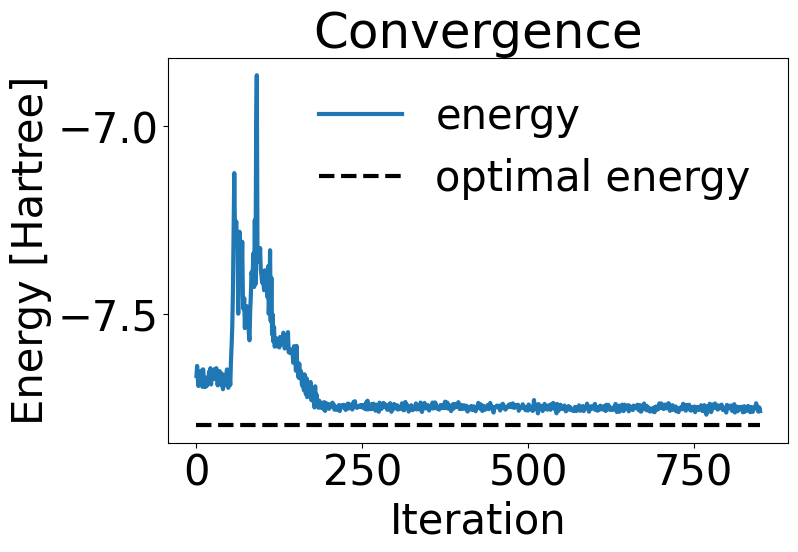

In [53]:
plot_convergence(values_hist2, 3, const_to_add_3)

In [ ]:
plot_energies(target_energies, calculated_energies, dists)